# Notes

## TODO
- We need to redo our `user_quality_3bins` around meaningful cutoffs. I think anything above ~75% is good, between 65-75% is neutral, and below 65% is bad. Or could be above 80% is good, 65-80 is fine, and below 65 is bad.
- Update the way we do the NaN replacements
- Incorporate the interaction stats tables, e.g., ml-cdmx-interaction-stats.csv
- We need time per pano

## Notes to self
- Ugh, we do have a confound in that the validation information is also coming from bad users... hmm.
- Can we predict the correctness of an individual label? (e.g., based on whether it has a tag, a severity rating, etc.)


# Imports

In [1]:
import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn stuff
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold

# Utility functions

In [89]:
map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']

map_group_to_marker = {'Anonymous':'o', 'Registered':'v', 'Researcher':'s', 'Turker':'*'}
map_quality_to_marker = {'Bad':'^', 'Good':'p', 'Neutral':'X', 'Very Bad':'d', 'Very Good':'P'}

map_markers = { 'role' : map_group_to_marker,
                'quality' : map_quality_to_marker,
                'user_quality_3bins': map_quality_to_marker,
                'user_quality_5bins': map_quality_to_marker}

def display_bycity_overview(df):
    grouped_by_city = df.groupby('city')
    
    df_result = grouped_by_city[['n_audit_mission', 'meters_audited', 'n_label', 'n_validation_received']].sum()
    df_result['num_users'] = grouped_by_city['city'].count()
    df_result['km_audited'] = df_result['meters_audited'] / 1000
    df_result.km_audited = df_result.km_audited.round(1)
    df_result.drop(columns='meters_audited', inplace=True)

    # reorder cols: https://stackoverflow.com/a/13148611
    #cols = df_result.columns.tolist()
    # cols = cols[-1:] + cols[:-1]
    cols = ['num_users', 'n_audit_mission', 'km_audited', 'n_label', 'n_validation_received']
    df_result = df_result[cols]
    df_result['Avg Accuracy'] = grouped_by_city['accuracy'].mean()
    df_result['Med Accuracy'] = grouped_by_city['accuracy'].median()
    df_result['SD Accuracy'] = grouped_by_city['accuracy'].std()

    df_result.loc['Total'] = df_result.sum()
    
    int_cols = ['num_users', 'n_audit_mission', 'n_label', 'n_validation_received']
    
    for col_name in int_cols:
        df_result[col_name] = df_result[col_name].fillna(0)
        df_result[col_name] = df_result[col_name].astype(int)
    
    df_result.at['Total', 'Avg Accuracy'] = df['accuracy'].mean()
    df_result.at['Total', 'Med Accuracy'] = df['accuracy'].median()
    df_result.at['Total', 'SD Accuracy'] = df['accuracy'].std()
    
    df_result.rename(columns={"n_validation_received": "Validations Received"}, inplace=True)
    
    df_result_styled = df_result.style.format({ 'km_audited': '{:.1f}',
        'Avg Accuracy': '{:.2%}', 'Med Accuracy': '{:.2%}', 'SD Accuracy': '{:.2%}'})
    display(df_result_styled)

def display_byrole_overview(df):
    grouped_by_role = df.groupby('role')

    df_result = grouped_by_role[['n_audit_mission', 'meters_audited', 'n_label', 'n_validation_received']].sum()
    df_result['num_users'] = grouped_by_role['role'].count()
    df_result['km_audited'] = df_result['meters_audited'] / 1000
    df_result.km_audited = df_result.km_audited.round(1)
    df_result.drop(columns='meters_audited', inplace=True)

    # reorder cols: https://stackoverflow.com/a/13148611
    #cols = df_result.columns.tolist()
    # cols = cols[-1:] + cols[:-1]
    cols = ['num_users', 'n_audit_mission', 'km_audited', 'n_label', 'n_validation_received']
    df_result = df_result[cols]
    df_result['Avg Accuracy'] = grouped_by_role['accuracy'].mean()
    df_result['Med Accuracy'] = grouped_by_role['accuracy'].median()
    df_result['SD Accuracy'] = grouped_by_role['accuracy'].std()

    if 'user_quality_3bins' in df.columns:
        grouped_by_role_and_quality = df_users.groupby(['user_quality_3bins', 'role'])
        df_result['Bad'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Bad']
        df_result['Neutral'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Neutral']
        df_result['Good'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Good']

    df_result.loc['Total'] = df_result.sum()
    
    int_cols = ['num_users', 'n_audit_mission', 'n_label', 'n_validation_received']
    
    if 'user_quality_3bins' in df.columns:
        int_cols.append(['Bad', 'Neutral', 'Good'])
    
    for col_name in int_cols:
        df_result[col_name] = df_result[col_name].fillna(0)
        df_result[col_name] = df_result[col_name].astype(int)
    
    df_result.at['Total', 'Avg Accuracy'] = df['accuracy'].mean()
    df_result.at['Total', 'Med Accuracy'] = df['accuracy'].median()
    df_result.at['Total', 'SD Accuracy'] = df['accuracy'].std()
    
    df_result.rename(columns={"n_validation_received": "Validations Received"}, inplace=True)
    
    #df_result2['meters_audited'] = df_result['meters_audited']
    display(df_result)

def plot_hist(df, col_name):
    import seaborn as sns, numpy as np

    plt.figure(figsize=(12, 6))
    ax = sns.histplot(df[col_name])
    plt.axvline(np.median(df[col_name]), color='b', linestyle='--', 
                label=f"Median: {np.median(df[col_name]):0.2f}", linewidth=1, alpha=0.8)
    plt.axvline(np.mean(df[col_name]), color='r', linestyle='-.', 
                label=f"Mean: {np.mean(df_users[col_name]):0.2f}", linewidth=1, alpha=0.8)
    ax.set_title(col_name)
    plt.legend()
    return ax
    
def plot_scatter(df, xcol_name, ycol_name, xlabel=None, ylabel=None, 
                 map_group_to_marker = None, xlim = None, ax = None,
                groupby='role'):
    groups = df.groupby(groupby)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    if map_group_to_marker is None:
        map_group_to_marker = map_markers[groupby]
    
    for name, group in groups:
        pairwise_corr = group[xcol_name].corr(group[ycol_name], method='pearson')
        #print(f"Corr of {xcol_name} to {ycol_name}: {cor}")
        ax.plot(group[xcol_name], group[ycol_name], marker=map_group_to_marker[name], 
                linestyle='', ms=10, alpha=0.65, label=f"{name} (r={pairwise_corr:0.2f})")
    ax.legend()
    
    if xlabel is None:
        xlabel = xcol_name
        
    if ylabel is None:
        ylabel = ycol_name
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(f"{xlabel} vs. {ylabel}")
    
    if xlim is not None:
        ax.set_xlim(xlim)
    #plt.show()
    return ax

def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues, figsize=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")

    # print(cm)
    if figsize is None:
        figsize = (12, 6)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #imshow displays data on a 2D raster
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


### FILE HANDLING ###
from os import listdir
import ntpath
import os

def get_csv_filenames(path_to_dir, suffix=".csv", include_path = True):
    """Gets all csv stat files in the directory"""
    filenames = listdir(path_to_dir)
    list_files = []
    for filename in filenames:
        filename_with_path = os.path.join(path_to_dir, filename)
        if filename.endswith(suffix) and 'interaction' not in filename.lower() and\
            filename.lower() != 'ml-codebook.csv':
            
            if include_path:
                list_files.append(filename_with_path)
            else:
                list_files.append(filename)
    return list_files
    
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

def extract_city_name(filename):
    """Utility function to extract city name from filename. Filenames should have format: ml-cityname-stats.csv"""
    just_filename = path_leaf(filename)
    start_split_index = just_filename.index('-', 2) + 1
    end_split_index = just_filename.index('-', start_split_index)
    return just_filename[start_split_index:end_split_index]

def read_and_parse_data_file(csv_file):
    df_users_for_city = pd.read_csv(csv_file) 
    # df_users_for_city.rename(columns = {'validation_count':'validations_received_count'}, inplace = True) 
    
    # Calculate accuracy column
    df_users_for_city['accuracy'] = ((df_users_for_city['n_validation_received'] - df_users_for_city['n_received_disagree']) / 
                                    df_users_for_city['n_validation_received'])
    
    
    # Calculate curb ramp accuracy
    df_users_for_city['n_received_curb_ramp_validations'] = df_users_for_city['n_received_curb_ramp_agree'] + \
                          df_users_for_city['n_received_curb_ramp_disagree'] + \
                          df_users_for_city['n_received_curb_ramp_unsure']
    
    df_users_for_city['curb_ramp_accuracy'] = ((df_users_for_city['n_received_curb_ramp_validations'] - df_users_for_city['n_received_curb_ramp_disagree']) / 
                                    df_users_for_city['n_received_curb_ramp_validations'])
    
    # Calculate missing curb ramp accuracy
    df_users_for_city['n_received_missing_curb_ramp_validations'] = df_users_for_city['n_received_missing_curb_ramp_agree'] + \
                          df_users_for_city['n_received_missing_curb_ramp_disagree'] + \
                          df_users_for_city['n_received_missing_curb_ramp_unsure']
    
    df_users_for_city['missing_curb_ramp_accuracy'] = ((df_users_for_city['n_received_missing_curb_ramp_validations'] - df_users_for_city['n_received_missing_curb_ramp_disagree']) / 
                                    df_users_for_city['n_received_missing_curb_ramp_validations'])
    
    # Calculate obstacle accuracy
    df_users_for_city['n_received_obstacle_validations'] = df_users_for_city['n_received_obstacle_agree'] + \
                          df_users_for_city['n_received_obstacle_disagree'] + \
                          df_users_for_city['n_received_obstacle_unsure']
    
    df_users_for_city['obstacle_accuracy'] = ((df_users_for_city['n_received_obstacle_validations'] - df_users_for_city['n_received_obstacle_disagree']) / 
                                    df_users_for_city['n_received_obstacle_validations'])
    
    # Calculate surface problem accuracy
    df_users_for_city['n_received_surface_problem_validations'] = df_users_for_city['n_received_surface_problem_agree'] + \
                          df_users_for_city['n_received_surface_problem_disagree'] + \
                          df_users_for_city['n_received_surface_problem_unsure']
    
    df_users_for_city['surface_problem_accuracy'] = ((df_users_for_city['n_received_surface_problem_validations'] - df_users_for_city['n_received_surface_problem_disagree']) / 
                                    df_users_for_city['n_received_surface_problem_validations'])
        
    # Add city name column
    city_name = extract_city_name(csv_file).capitalize()
    df_users_for_city['city'] = city_name
    
    return df_users_for_city

def read_and_parse_data_files(csv_files, verbose = True):
    list_dfs = []
    for csv_file in csv_files:
        print(f"Reading in {csv_file}")
        df = read_and_parse_data_file(csv_file)
        if verbose:
            print(f"Read in {len(df)} users from {csv_file}")
            #display(df_users.groupby('role')['role', 'high_quality_manual'].count())
            display_byrole_overview(df)
        list_dfs.append(df)
    df_users = pd.concat(list_dfs)
    
    # because we are concatenating DataFrames, the indexes won't be unique. This will
    # totally mess us up, so need to reindex
    if not df_users.index.is_unique:
        print("The DataFrame indexes are not unique, reindexing...")
        df_users.reset_index(inplace=True, drop=True)
        print("df_users.index.is_unique=",df_users.index.is_unique)
    
    return df_users

# Read in data

In [79]:
def read_base_data_file(base_data_file):
    base_df = pd.read_csv(base_data_file) 
    
    for city in base_df['city'].unique():
        df_users_for_city = base_df[base_df['city'] == city]
        
        # TODO: Really, these accuracy calculations should be performed at the per label level for each user
        # since each label can receive multiple validations and we'd want to score this appropriately
        # As now, we are dealing with aggregate data, so we can't calculate things at a per label level
        # (Mikey would have to do this)
        
        # Calculate accuracy column
        base_df.loc[base_df['city'] == city, 'accuracy'] =\
                ((df_users_for_city['n_validation_received'] - df_users_for_city['n_received_disagree']) / 
                                        df_users_for_city['n_validation_received'])


        # Count total number of curb ramp validations received
        base_df.loc[base_df['city'] == city, 'n_received_curb_ramp_validations'] =\
                              df_users_for_city['n_received_curb_ramp_agree'] + \
                              df_users_for_city['n_received_curb_ramp_disagree'] + \
                              df_users_for_city['n_received_curb_ramp_unsure']
        
        # Count total number of missing curb ramp validations received
        base_df.loc[base_df['city'] == city, 'n_received_missing_curb_ramp_validations'] =\
                              df_users_for_city['n_received_missing_curb_ramp_agree'] + \
                              df_users_for_city['n_received_missing_curb_ramp_disagree'] + \
                              df_users_for_city['n_received_missing_curb_ramp_unsure']
        
        # Count total number of obstacle validations received
        base_df.loc[base_df['city'] == city, 'n_received_obstacle_validations'] =\
                              df_users_for_city['n_received_obstacle_agree'] + \
                              df_users_for_city['n_received_obstacle_disagree'] + \
                              df_users_for_city['n_received_obstacle_unsure']
        
        # Count total number of surface problem validations received
        base_df.loc[base_df['city'] == city, 'n_received_surface_problem_validations'] =\
                              df_users_for_city['n_received_surface_problem_agree'] + \
                              df_users_for_city['n_received_surface_problem_disagree'] + \
                              df_users_for_city['n_received_surface_problem_unsure']

        df_users_for_city = base_df[base_df['city'] == city]
        
        # Calculate curb ramp accuracy per user
        base_df.loc[base_df['city'] == city, 'curb_ramp_accuracy'] =\
            ((df_users_for_city['n_received_curb_ramp_validations'] - df_users_for_city['n_received_curb_ramp_disagree']) / 
                                        df_users_for_city['n_received_curb_ramp_validations'])



        # Calculate missing curb ramp accuracy per user
        base_df.loc[base_df['city'] == city, 'missing_curb_ramp_accuracy'] =\
            ((df_users_for_city['n_received_missing_curb_ramp_validations'] - df_users_for_city['n_received_missing_curb_ramp_disagree']) / 
                                        df_users_for_city['n_received_missing_curb_ramp_validations'])



        # Calculate obstacle accuracy per user
        base_df.loc[base_df['city'] == city, 'obstacle_accuracy'] =\
            ((df_users_for_city['n_received_obstacle_validations'] - df_users_for_city['n_received_obstacle_disagree']) / 
                                        df_users_for_city['n_received_obstacle_validations'])



        # Calculate surface problem accuracy per user
        base_df.loc[base_df['city'] == city, 'surface_problem_accuracy'] =\
            ((df_users_for_city['n_received_surface_problem_validations'] - df_users_for_city['n_received_surface_problem_disagree']) / 
                                        df_users_for_city['n_received_surface_problem_validations'])
        
    return base_df

def read_interaction_stats_file(interaction_stats_file):
    interaction_stats_df = pd.read_csv(interaction_stats_file) 
    
    interaction_stats_df['labels_per_pano_visited'] = interaction_stats_df['n_pano_with_label'] / interaction_stats_df['n_pano_visited']
    interaction_stats_df['keyboard_interactions_per_pano_visited'] = interaction_stats_df['n_keyboard_interaction'] / interaction_stats_df['n_pano_visited']
    interaction_stats_df['panning_interactions_per_pano_visited'] = interaction_stats_df['n_pan_interaction'] / interaction_stats_df['n_pano_visited']
    
    return interaction_stats_df
    
def read_data_files(path_to_data):
    base_data_filename = 'ml-stats.csv'
    interaction_stats_filename = 'ml-interaction-stats.csv'
    print(f"Reading in {path_to_data}")
    base_df = read_base_data_file(os.path.join(path_to_data, base_data_filename))
    interaction_stats_df = read_interaction_stats_file(os.path.join(path_to_data, interaction_stats_filename))
    
    # Perform a join on the user_id key between the two tables
    # See: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    del interaction_stats_df['city']
    df_users = pd.merge(base_df, interaction_stats_df, on='user_id', validate="one_to_one")
    display(df_users)
    return df_users
    
df_users = read_data_files('data')

# make a copy of the original DataFrame just in case we need it. We'll save
# the cleaned one in the original df_users DataFrame
df_users_original = df_users.copy()

display_bycity_overview(df_users)
display_byrole_overview(df_users)

Reading in data


,user_id,city,role,n_validation_received,n_received_agree,n_received_disagree,n_received_unsure,n_received_tie,n_received_curb_ramp,n_received_curb_ramp_agree,...,missing_curb_ramp_accuracy,obstacle_accuracy,surface_problem_accuracy,n_pano_visited,n_pano_with_label,n_keyboard_interaction,n_pan_interaction,labels_per_pano_visited,keyboard_interactions_per_pano_visited,panning_interactions_per_pano_visited
0,04a5aab0-82ac-44a4-8a23-47b27d129336,pittsburgh,Registered,36,33,2,1,0,10,9,...,0.909091,0.75,1.000000,158,101,770,17743,0.639241,4.873418,112.297468
1,06dcb7c3-b401-4602-b82d-73f4254d303a,pittsburgh,Registered,24,23,1,0,0,11,10,...,1.000000,NaN,1.000000,128,49,49,12150,0.382812,0.382812,94.921875
2,08a16a7a-a1a0-478b-b3c4-2e351327fc10,pittsburgh,Registered,37,28,8,1,0,11,9,...,0.818182,1.00,0.600000,127,115,72,12403,0.905512,0.566929,97.661417
3,09dbf533-30f3-4aac-b550-77654f8de0d3,pittsburgh,Registered,10,7,3,0,0,2,2,...,0.000000,NaN,0.833333,169,39,57,12793,0.230769,0.337278,75.698225
4,0a9745e1-a0cb-4fa1-9fbf-aeb71fa83696,pittsburgh,Registered,12,11,1,0,0,10,9,...,1.000000,1.00,NaN,145,49,3,11556,0.337931,0.020690,79.696552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,fdab54f3-436d-404d-bdd6-455e9afd3e53,seattle,Anonymous,25,6,12,3,4,0,0,...,NaN,0.45,0.000000,30,21,3,3666,0.700000,0.100000,122.200000
1539,fdd004f0-7eb1-4a61-ae2e-8aea7bc98e2c,seattle,Registered,45,33,3,1,8,11,11,...,1.000000,NaN,0.785714,38,15,215,8354,0.394737,5.657895,219.842105
1540,fe6eadd3-b972-48b4-8360-14862d2e58b6,seattle,Anonymous,30,23,3,0,4,21,21,...,0.000000,0.50,NaN,94,13,45,8882,0.138298,0.478723,94.489362
1541,fed79f3e-f388-439d-a2dc-902ae8456a0c,seattle,Registered,48,35,4,0,9,22,22,...,0.666667,0.80,1.000000,979,23,14,26700,0.023493,0.014300,27.272727


,num_users,n_audit_mission,km_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
city,,,,,,,,
cdmx,155,2862,425.1,30656,15457,87.03%,87.88%,8.44%
chicago,78,1043,145.6,8160,6582,76.00%,79.05%,15.92%
columbus,144,1832,363.1,28601,12003,86.12%,87.97%,10.79%
newberg,60,831,230.9,16570,8464,83.01%,91.01%,20.96%
pittsburgh,49,896,167.6,13473,1908,85.67%,89.66%,15.23%
seattle,750,13285,2781.3,165258,100163,84.78%,88.68%,14.10%
spgg,307,7215,1270.0,101414,28903,85.28%,86.96%,10.11%
Total,1543,27964,5383.6,364132,173480,84.75%,87.76%,13.27%


,num_users,n_audit_mission,km_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,446,1074,188.9,13730,10599,0.853723,0.888889,0.138639
Registered,886,22228,3927.4,262439,117082,0.848885,0.873060,0.117296
Researcher,29,924,206.9,20500,11426,0.908638,0.927461,0.103010
Turker,182,3738,1060.3,67463,34373,0.815656,0.875000,0.179334
Total,1543,27964,5383.5,364132,173480,0.847479,0.877551,0.132707


In [80]:
print(f"We have {len(df_users)} users across {len(pd.unique(df_users['city']))} cities: {pd.unique(df_users['city'])}")

display_bycity_overview(df_users)

display_byrole_overview(df_users)

We have 1543 users across 7 cities: ['pittsburgh' 'chicago' 'newberg' 'columbus' 'cdmx' 'spgg' 'seattle']


,num_users,n_audit_mission,km_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
city,,,,,,,,
cdmx,155,2862,425.1,30656,15457,87.03%,87.88%,8.44%
chicago,78,1043,145.6,8160,6582,76.00%,79.05%,15.92%
columbus,144,1832,363.1,28601,12003,86.12%,87.97%,10.79%
newberg,60,831,230.9,16570,8464,83.01%,91.01%,20.96%
pittsburgh,49,896,167.6,13473,1908,85.67%,89.66%,15.23%
seattle,750,13285,2781.3,165258,100163,84.78%,88.68%,14.10%
spgg,307,7215,1270.0,101414,28903,85.28%,86.96%,10.11%
Total,1543,27964,5383.6,364132,173480,84.75%,87.76%,13.27%


,num_users,n_audit_mission,km_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,446,1074,188.9,13730,10599,0.853723,0.888889,0.138639
Registered,886,22228,3927.4,262439,117082,0.848885,0.873060,0.117296
Researcher,29,924,206.9,20500,11426,0.908638,0.927461,0.103010
Turker,182,3738,1060.3,67463,34373,0.815656,0.875000,0.179334
Total,1543,27964,5383.5,364132,173480,0.847479,0.877551,0.132707


## Data cleansing and processing

In [81]:
# filtering thresholds
min_validations_rcvd_threshold = 10
min_num_labels_threshold = 10
min_missions_completed = 0

# Grab original dataframe
df_users = df_users_original.copy()

# Remove users who have audited < 0 meters
if len(df_users[df_users.meters_audited < 0]) > 0:
    print(f"The following indices have meters_audited < 0: {df_users[df_users.meters_audited < 0].index}")
    df_users.drop(df_users[df_users.meters_audited < 0].index, inplace=True)
    print("len(df_users) =",len(df_users))

# Remove users who have not finished a mission
query_result = df_users[df_users.n_audit_mission < min_missions_completed]
# print(query_result)
#display_users(query_result)
num_users_who_never_finished_a_mission = len(query_result)
print("{}/{} users ({:0.1f}%) never completed {} missions. Removing them from analysis.".format(
    num_users_who_never_finished_a_mission, len(df_users), 
    num_users_who_never_finished_a_mission / len(df_users) * 100,
    min_missions_completed))
df_users.drop(query_result.index, inplace=True)

# Remove users who have not provided a minimum number of labels
query_result = df_users[df_users.n_label < min_num_labels_threshold]
num_users_without_min_labels = len(query_result)
#display_users(query_result)
print("{}/{} users ({:0.1f}%) have not provided the min num of labels of {}. Removing them from analysis.".format(
    num_users_without_min_labels, len(df_users), 
    num_users_without_min_labels / len(df_users) * 100, min_num_labels_threshold))
df_users.drop(query_result.index, inplace=True)

# Remove users who have not received the minimum number of validations
query_result = df_users[df_users.n_validation_received < min_validations_rcvd_threshold]
num_users_without_min_validations_rcvd = len(query_result)
print("{}/{} users ({:0.1f}%) have not received the min num of validations of {}. Removing them from analysis.".format(
    num_users_without_min_validations_rcvd, len(df_users), 
    num_users_without_min_validations_rcvd / len(df_users) * 100, min_validations_rcvd_threshold))
df_users.drop(query_result.index, inplace=True)

# add in labels per meter
df_users['labels_per_meter'] = df_users['n_label'] / df_users['meters_audited']
df_users['curb_ramp_labels_per_meter'] = df_users['n_curb_ramp'] / df_users['meters_audited']
df_users['missing_curb_ramp_labels_per_meter'] = df_users['n_missing_curb_ramp'] / df_users['meters_audited']
df_users['obstacle_labels_per_meter'] = df_users['n_obstacle'] / df_users['meters_audited']
df_users['surface_problem_labels_per_meter'] = df_users['n_surface_problem'] / df_users['meters_audited']
df_users['no_sidewalk_labels_per_meter'] = df_users['n_no_sidewalk'] / df_users['meters_audited']

# Replace np.nan, np.inf, -np.inf
df_users['labels_per_meter'].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

# convert high quality column to boolean
df_users['high_quality_manual'].replace(['f'], False, inplace=True)
df_users['high_quality_manual'].replace(['t'], True, inplace=True)
df_users['high_quality_manual'] = df_users['high_quality_manual'].astype('bool')

# add in percentage of labels that have severity
df_users['labels_with_severity_fraction'] = df_users['n_label_with_severity'] / df_users['n_label']
df_users['curb_ramps_with_severity_fraction'] = df_users['n_curb_ramp_with_severity'] / df_users['n_curb_ramp']
df_users['missing_curb_ramps_with_severity_fraction'] = df_users['n_missing_curb_ramp_with_severity'] / df_users['n_missing_curb_ramp']
df_users['obstacles_with_severity_fraction'] = df_users['n_obstacle_with_severity'] / df_users['n_obstacle']
df_users['surface_problems_with_severity_fraction'] = df_users['n_surface_problem_with_severity'] / df_users['n_surface_problem']
df_users['no_sidewalks_with_severity_fraction'] = df_users['n_no_sidewalk_with_severity'] / df_users['n_no_sidewalk']

# add in percentage of labels that have tags
df_users['labels_with_tags_fraction'] = df_users['n_label_with_tag'] / df_users['n_label']
df_users['curb_ramps_with_tags_fraction'] = df_users['n_curb_ramp_with_tag'] / df_users['n_curb_ramp']
df_users['missing_curb_ramps_with_tags_fraction'] = df_users['n_missing_curb_ramp_with_tag'] / df_users['n_missing_curb_ramp']
df_users['obstacles_with_tags_fraction'] = df_users['n_obstacle_with_tag'] / df_users['n_obstacle']
df_users['surface_problems_with_tags_fraction'] = df_users['n_surface_problem_with_tag'] / df_users['n_surface_problem']
df_users['no_sidewalks_with_tags_fraction'] = df_users['n_no_sidewalk_with_tag'] / df_users['n_no_sidewalk']

# add in quality groupings
quality_bin_labels_5 = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Very Good']
df_users['user_quality_5bins'] = pd.qcut(df_users['accuracy'], 5, labels=quality_bin_labels_5)

quality_bin_labels_3 = ['Bad', 'Neutral', 'Good']
df_users['user_quality_3bins'] = pd.qcut(df_users['accuracy'], 3, labels=quality_bin_labels_3)

# print out total number filtered out
total_filtered = len(df_users_original) - len(df_users)
total_filtered_percentage = total_filtered / len(df_users_original) * 100
print(f"We filtered out {total_filtered}/{len(df_users_original)} users ({total_filtered_percentage:.2f}%)")
print(f"{len(df_users)} total users remain across the {len(pd.unique(df_users['city']))} cities")

# Replace NaN with the mean of the respective columns
cols_with_nan = df_users_original.columns[df_users_original.isna().any()].tolist()
if len(cols_with_nan) > 0:
    print("-------")
    print(f"The following {len(cols_with_nan)}/{len(df_users.columns)} column(s) have NaN data ({len(cols_with_nan)/len(df_users.columns):0.2%} of columns)")
    print(df_users_original.isna().sum()[cols_with_nan])   
    
    #print(f"Empty cells in these {len(cols_with_nan)} column(s) will be replaced by the mean of their respective columns")
    # df_users.fillna(df_users.mean(), inplace=True)

0/1543 users (0.0%) never completed 0 missions. Removing them from analysis.
0/1543 users (0.0%) have not provided the min num of labels of 10. Removing them from analysis.
26/1543 users (1.7%) have not received the min num of validations of 10. Removing them from analysis.
We filtered out 26/1543 users (1.69%)
1517 total users remain across the 7 cities
-------
The following 32/138 column(s) have NaN data (23.19% of columns)
high_quality_manual                1444
label_severity_min                    1
label_severity_max                    1
label_severity_mean                   1
label_severity_sd                     1
curb_ramp_severity_min               99
curb_ramp_severity_max               99
curb_ramp_severity_mean              99
curb_ramp_severity_sd               152
missing_curb_ramp_severity_min      214
missing_curb_ramp_severity_max      214
missing_curb_ramp_severity_mean     214
missing_curb_ramp_severity_sd       326
obstacle_severity_min               345
obstacle_s

In [82]:
#display(df_users.groupby('role')['audit_mission_count', 'meters_audited', 'n_label'].sum())
print(f"Before data cleansing: {len(pd.unique(df_users_original['city']))} cities: {pd.unique(df_users_original['city']).tolist()}")
display_bycity_overview(df_users_original)

print(f"After data cleansing: {len(pd.unique(df_users['city']))} cities: {pd.unique(df_users['city']).tolist()}")
display_bycity_overview(df_users)

Before data cleansing: 7 cities: ['pittsburgh', 'chicago', 'newberg', 'columbus', 'cdmx', 'spgg', 'seattle']


,num_users,n_audit_mission,km_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
city,,,,,,,,
cdmx,155,2862,425.1,30656,15457,87.03%,87.88%,8.44%
chicago,78,1043,145.6,8160,6582,76.00%,79.05%,15.92%
columbus,144,1832,363.1,28601,12003,86.12%,87.97%,10.79%
newberg,60,831,230.9,16570,8464,83.01%,91.01%,20.96%
pittsburgh,49,896,167.6,13473,1908,85.67%,89.66%,15.23%
seattle,750,13285,2781.3,165258,100163,84.78%,88.68%,14.10%
spgg,307,7215,1270.0,101414,28903,85.28%,86.96%,10.11%
Total,1543,27964,5383.6,364132,173480,84.75%,87.76%,13.27%


After data cleansing: 7 cities: ['pittsburgh', 'chicago', 'newberg', 'columbus', 'cdmx', 'spgg', 'seattle']


,num_users,n_audit_mission,km_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
city,,,,,,,,
cdmx,150,2857,424.7,30569,15432,86.91%,87.82%,8.21%
chicago,78,1043,145.6,8160,6582,76.00%,79.05%,15.92%
columbus,141,1826,362.4,28558,11986,86.28%,88.14%,10.77%
newberg,58,826,230.2,16541,8456,83.36%,91.34%,20.96%
pittsburgh,42,845,161.0,13123,1874,87.00%,90.03%,8.49%
seattle,744,13272,2779.9,165168,100131,84.72%,88.66%,14.12%
spgg,304,7213,1269.5,101370,28882,85.28%,86.88%,10.07%
Total,1517,27882,5373.3,363489,173343,84.76%,87.72%,13.10%


In [49]:
df_users.sample(5)

,user_id,city,role,n_validation_received,n_received_agree,n_received_disagree,n_received_unsure,n_received_tie,n_received_curb_ramp,n_received_curb_ramp_agree,...,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction,labels_with_tags_fraction,curb_ramps_with_tags_fraction,missing_curb_ramps_with_tags_fraction,obstacles_with_tags_fraction,surface_problems_with_tags_fraction,no_sidewalks_with_tags_fraction,user_quality_5bins,user_quality_3bins
656,90a6a6be-5f46-4c84-a1ae-095f3b989027,spgg,Registered,176,142,21,8,5,19,10,...,0.988550,1.0,0.963774,0.789474,0.633333,0.985915,0.984733,0.918033,Neutral,Neutral
527,2608c2e5-5c0b-4c62-a0e3-f93220fbe6eb,spgg,Registered,54,40,12,1,1,7,3,...,0.933333,1.0,0.973333,0.857143,1.000000,0.909091,1.000000,1.000000,Bad,Bad
330,fd73de2e-ad72-4570-abb8-8caf1643f234,columbus,Registered,21,17,4,0,0,10,10,...,NaN,NaN,0.782609,0.600000,0.000000,1.000000,NaN,NaN,Bad,Bad
547,324ed4b4-85b7-479d-9434-3ebd93d6c578,spgg,Anonymous,16,10,2,1,3,1,0,...,1.000000,NaN,0.937500,1.000000,1.000000,0.875000,1.000000,NaN,Neutral,Neutral
1012,4761a83c-d4af-4847-892b-f340b8fcfe06,seattle,Registered,39,27,8,1,3,31,21,...,NaN,NaN,0.250000,0.150000,1.000000,0.333333,NaN,NaN,Bad,Bad


# Exploratory analysis

In [50]:
df_users.groupby('role').describe()

n_validation_received                                             \
                           count        mean         std   min   25%    50%   
role                                                                          
Anonymous                  431.0   24.394432   26.480047  10.0  13.0   17.0   
Registered                 876.0  133.605023  471.606084  10.0  25.0   47.0   
Researcher                  28.0  407.785714  434.685357  12.0  37.5  260.0   
Turker                     182.0  188.862637  557.507583  10.0  15.0   24.0   

                           n_received_agree              ...  \
               75%     max            count        mean  ...   
role                                                     ...   
Anonymous    26.00   306.0            431.0   17.083527  ...   
Registered   98.25  6986.0            876.0  102.183790  ...   
Researcher  637.75  1547.0             28.0  331.607143  ...   
Turker       48.25  4135.0            182.0  139.769231  ...   

           surface_problems_with_tags_fraction       \
                                           75%  max   
role                                                  
Anonymous                             1.000000  1.0   
Registered                            1.000000  1.0   
Researcher                            0.978101  1.0   
Turker                                1.000000  1.0   

           no_sidewalks_with_tags_fraction                                     \
                                     count      mean       std  min       25%   
role                                                                            
Anonymous                            173.0  0.771762  0.356090  0.0  0.666667   
Registered                           647.0  0.800403  0.310946  0.0  0.724213   
Researcher                            25.0  0.588899  0.408075  0.0  0.169492   
Turker                                95.0  0.624145  0.426065  0.0  0.065239   

                                     
                 50%       75%  max  
role                                 
Anonymous   1.000000  1.000000  1.0  
Registered  0.973451  1.000000  1.0  
Researcher  0.736842  0.959184  1.0  
Turker      0.878049  1.000000  1.0  

[4 rows x 1032 columns]

In [51]:
df_users.groupby('city').describe()

n_validation_received                                             \
                           count        mean         std   min    25%   50%   
city                                                                          
cdmx                       150.0  102.880000  170.175666  11.0  32.00  58.0   
chicago                     78.0   84.384615  181.864316  10.0  18.25  33.5   
columbus                   141.0   85.007092  157.675141  10.0  19.00  41.0   
newberg                     58.0  145.793103  280.543380  10.0  14.25  23.0   
pittsburgh                  42.0   44.619048   53.095382  10.0  24.00  29.5   
seattle                    744.0  134.584677  571.472397  10.0  15.00  23.5   
spgg                       304.0   95.006579  128.723153  10.0  21.75  57.0   

                           n_received_agree              ...  \
               75%     max            count        mean  ...   
city                                                     ...   
cdmx        115.25  1620.0            150.0   81.020000  ...   
chicago      52.50   999.0             78.0   58.820513  ...   
columbus     69.00  1391.0            141.0   69.255319  ...   
newberg     121.25  1547.0             58.0  109.844828  ...   
pittsburgh   35.75   309.0             42.0   37.690476  ...   
seattle      46.00  6986.0            744.0  101.076613  ...   
spgg        125.00  1109.0            304.0   72.164474  ...   

           surface_problems_with_tags_fraction       \
                                           75%  max   
city                                                  
cdmx                                       1.0  1.0   
chicago                                    1.0  1.0   
columbus                                   1.0  1.0   
newberg                                    1.0  1.0   
pittsburgh                                 1.0  1.0   
seattle                                    1.0  1.0   
spgg                                       1.0  1.0   

           no_sidewalks_with_tags_fraction                                     \
                                     count      mean       std  min       25%   
city                                                                            
cdmx                                 116.0  0.827893  0.295646  0.0  0.794444   
chicago                               46.0  0.855855  0.279909  0.0  0.878472   
columbus                             109.0  0.785558  0.296445  0.0  0.677419   
newberg                               46.0  0.739700  0.375167  0.0  0.538950   
pittsburgh                            38.0  0.802969  0.280696  0.0  0.750000   
seattle                              360.0  0.738937  0.377472  0.0  0.538397   
spgg                                 225.0  0.772465  0.328100  0.0  0.666667   

                                
                 50%  75%  max  
city                            
cdmx        1.000000  1.0  1.0  
chicago     1.000000  1.0  1.0  
columbus    0.921569  1.0  1.0  
newberg     0.965839  1.0  1.0  
pittsburgh  0.906140  1.0  1.0  
seattle     0.995556  1.0  1.0  
spgg        0.971429  1.0  1.0  

[7 rows x 1032 columns]

In [52]:
display(df_users.sort_values(by=['labels_per_meter'], ascending=False).head(5))

,user_id,city,role,n_validation_received,n_received_agree,n_received_disagree,n_received_unsure,n_received_tie,n_received_curb_ramp,n_received_curb_ramp_agree,...,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction,labels_with_tags_fraction,curb_ramps_with_tags_fraction,missing_curb_ramps_with_tags_fraction,obstacles_with_tags_fraction,surface_problems_with_tags_fraction,no_sidewalks_with_tags_fraction,user_quality_5bins,user_quality_3bins
1301,ae3df547-bdff-4911-9642-6ba145697013,seattle,Anonymous,10,10,0,0,0,10,10,...,NaN,NaN,0.300000,0.30,NaN,NaN,NaN,NaN,Very Good,Good
827,0c74f7a8-9171-47c8-90fc-104e1a1b140a,seattle,Anonymous,15,11,1,0,3,8,8,...,NaN,NaN,0.466667,0.00,NaN,1.0,NaN,NaN,Good,Good
1108,6f34ace7-1c6e-4640-b092-2d2aed50b02b,seattle,Turker,10,8,2,0,0,4,4,...,NaN,NaN,0.700000,1.00,0.5,NaN,NaN,NaN,Bad,Bad
517,1d27adc6-01e9-4d7d-8411-3e0eee2ef634,spgg,Anonymous,13,13,0,0,0,0,0,...,1.0,NaN,1.000000,NaN,1.0,1.0,1.0,NaN,Very Good,Good
900,2142b941-30fd-4ee7-ad9e-f864bea67b45,seattle,Turker,10,5,4,0,1,4,2,...,1.0,NaN,0.300000,0.25,0.5,0.0,0.0,NaN,Very Bad,Bad


In [53]:
display(df_users.sort_values(by=['accuracy', 'labels_per_meter'], ascending=False).head(5))

,user_id,city,role,n_validation_received,n_received_agree,n_received_disagree,n_received_unsure,n_received_tie,n_received_curb_ramp,n_received_curb_ramp_agree,...,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction,labels_with_tags_fraction,curb_ramps_with_tags_fraction,missing_curb_ramps_with_tags_fraction,obstacles_with_tags_fraction,surface_problems_with_tags_fraction,no_sidewalks_with_tags_fraction,user_quality_5bins,user_quality_3bins
1301,ae3df547-bdff-4911-9642-6ba145697013,seattle,Anonymous,10,10,0,0,0,10,10,...,NaN,NaN,0.300000,0.3,NaN,NaN,NaN,NaN,Very Good,Good
517,1d27adc6-01e9-4d7d-8411-3e0eee2ef634,spgg,Anonymous,13,13,0,0,0,0,0,...,1.000000,NaN,1.000000,NaN,1.0,1.0,1.000000,NaN,Very Good,Good
1183,8789dea2-9e46-49a6-9026-501052357a97,seattle,Anonymous,10,10,0,0,0,9,9,...,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,Very Good,Good
748,dcd750b1-252b-4fa0-bd00-9974ba86423e,spgg,Registered,14,11,0,0,3,0,0,...,0.714286,NaN,0.785714,NaN,0.6,0.5,1.000000,NaN,Very Good,Good
104,bb3f9414-bb24-4037-93d3-ebeab1c886de,chicago,Anonymous,17,12,0,0,5,2,2,...,0.923077,0.0,0.326923,1.0,1.0,NaN,0.846154,0.0,Very Good,Good


In [ ]:
# Data overview

array([[<AxesSubplot:title={'center':'cdmx'}>,
        <AxesSubplot:title={'center':'chicago'}>,
        <AxesSubplot:title={'center':'columbus'}>],
       [<AxesSubplot:title={'center':'newberg'}>,
        <AxesSubplot:title={'center':'pittsburgh'}>,
        <AxesSubplot:title={'center':'seattle'}>],
       [<AxesSubplot:title={'center':'spgg'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

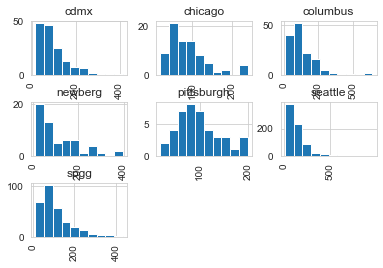

In [85]:
#     interaction_stats_df['labels_per_pano_visited'] = interaction_stats_df['n_pano_with_label'] / interaction_stats_df['n_pano_visited']
#     interaction_stats_df['keyboard_interactions_per_pano_visited'] = interaction_stats_df['n_keyboard_interaction'] / interaction_stats_df['n_pano_visited']
#     interaction_stats_df['panning_interactions_per_pano_visited'] =
    
df_users.hist(column='panning_interactions_per_pano_visited', by='city')

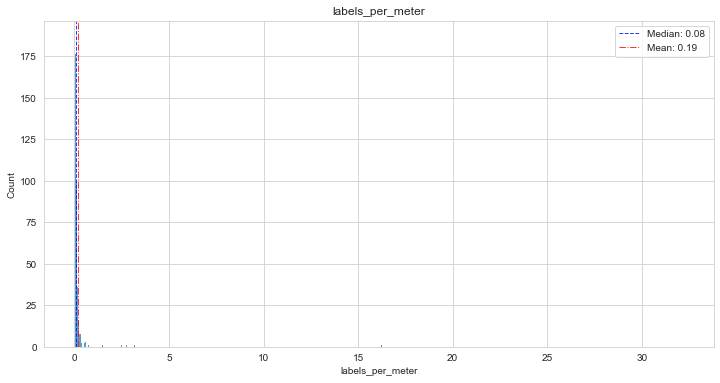

In [90]:
plot_hist(df_users, 'labels_per_meter')

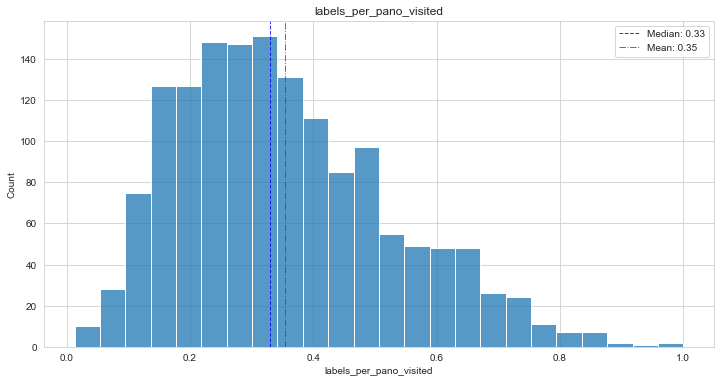

In [94]:
plot_hist(df_users, 'labels_per_pano_visited')

## Scatter plots of features

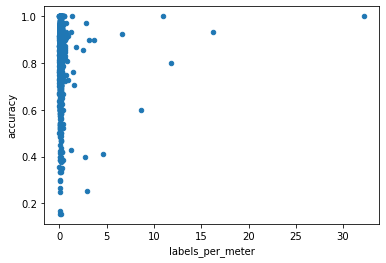

In [54]:
# We can use Pandas to create a scatter plot directly but hard to color by user group
ax = df_users.plot.scatter(x='labels_per_meter', y='accuracy')

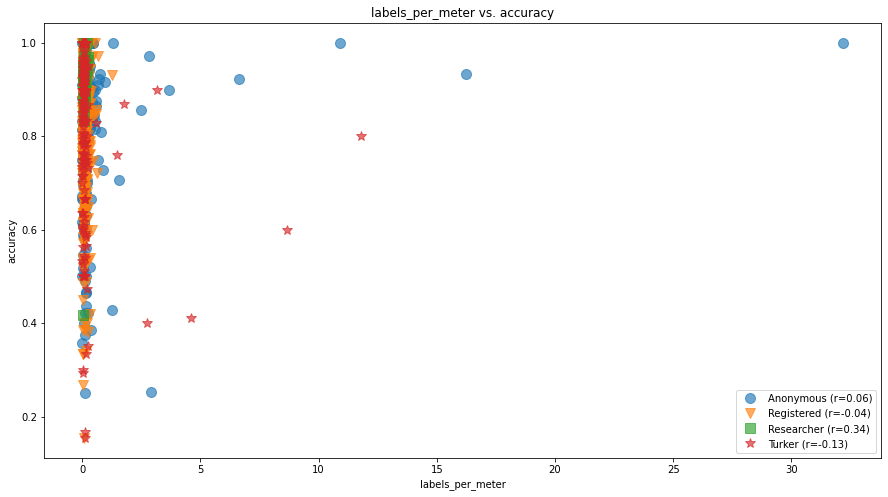

In [55]:
# So I made my own scatter plot. Let's look at the relationship between labels_per_meter and accuracy
plot_scatter(df_users, 'labels_per_meter', 'accuracy');

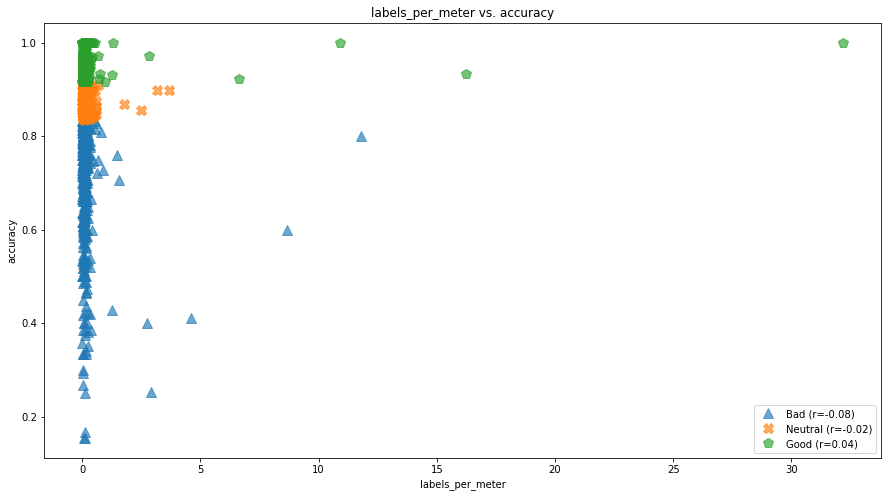

In [56]:
plot_scatter(df_users, 'labels_per_meter', 'accuracy', groupby='user_quality_3bins');

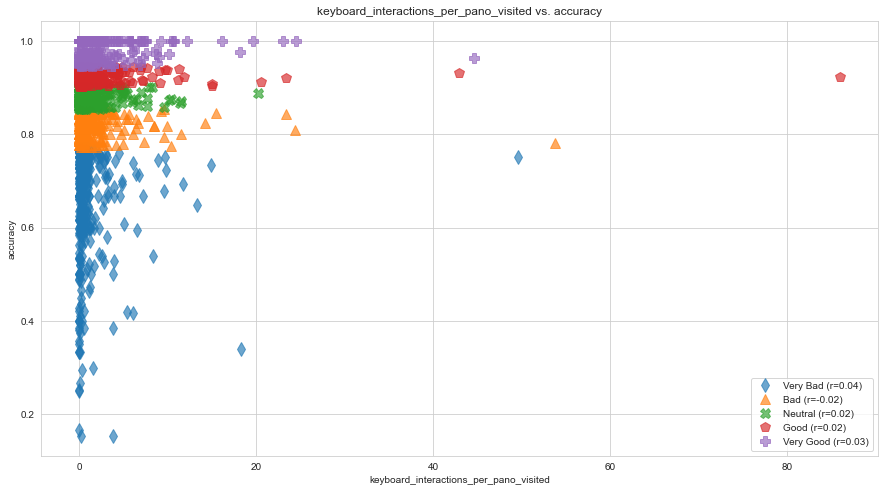

In [88]:
plot_scatter(df_users, 'keyboard_interactions_per_pano_visited', 'accuracy', groupby='user_quality_5bins');

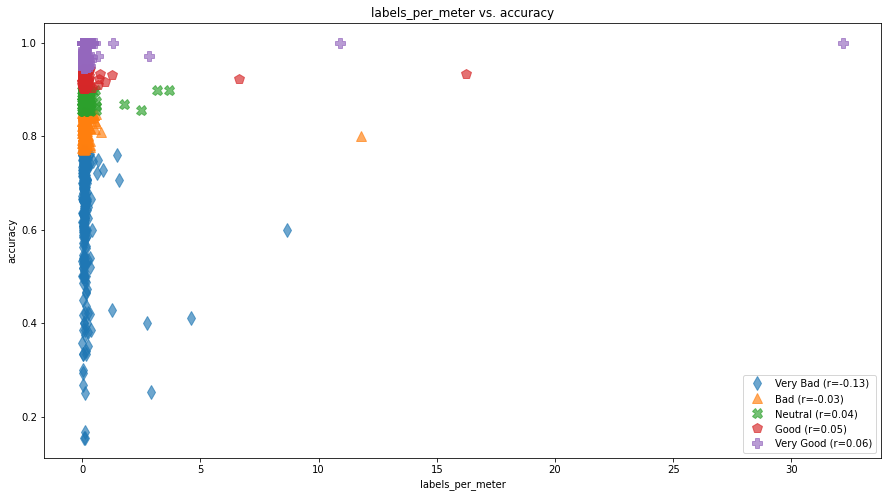

In [57]:
plot_scatter(df_users, 'labels_per_meter', 'accuracy', groupby='user_quality_5bins');

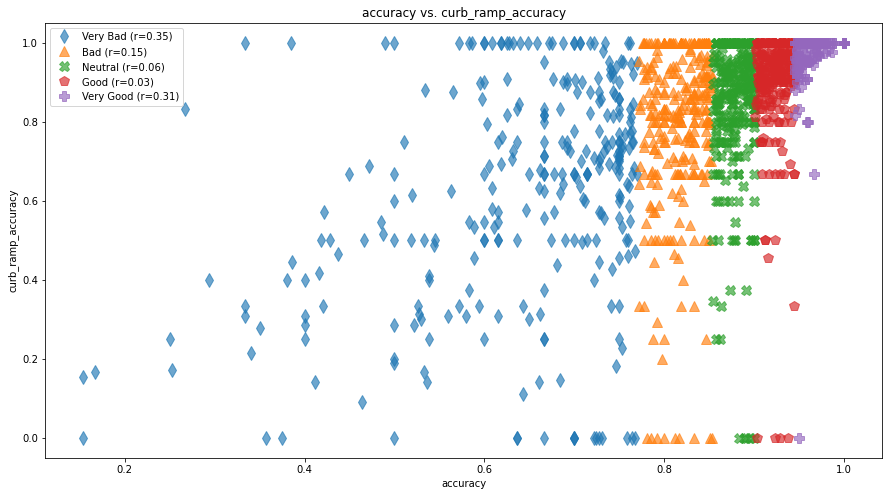

In [58]:
plot_scatter(df_users, 'accuracy', 'curb_ramp_accuracy', groupby='user_quality_5bins');

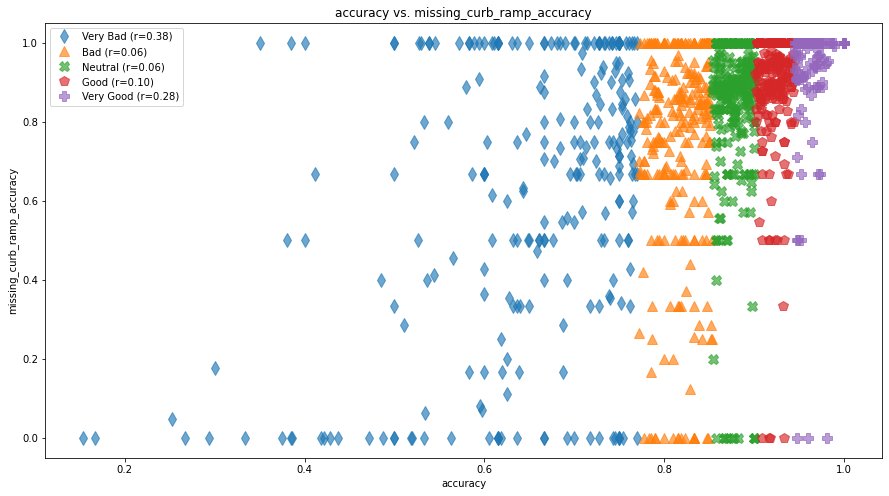

In [59]:
plot_scatter(df_users, 'accuracy', 'missing_curb_ramp_accuracy', groupby='user_quality_5bins');

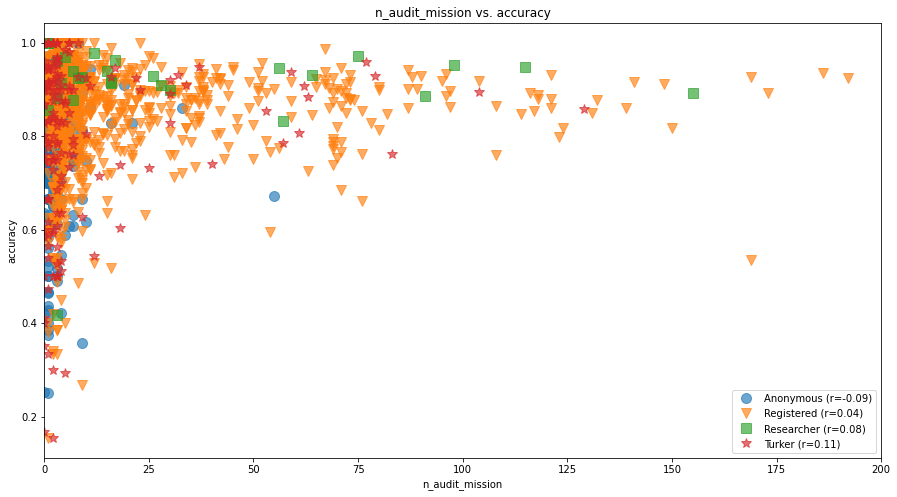

In [60]:
plot_scatter(df_users, 'n_audit_mission', 'accuracy', xlim=(0, 200));

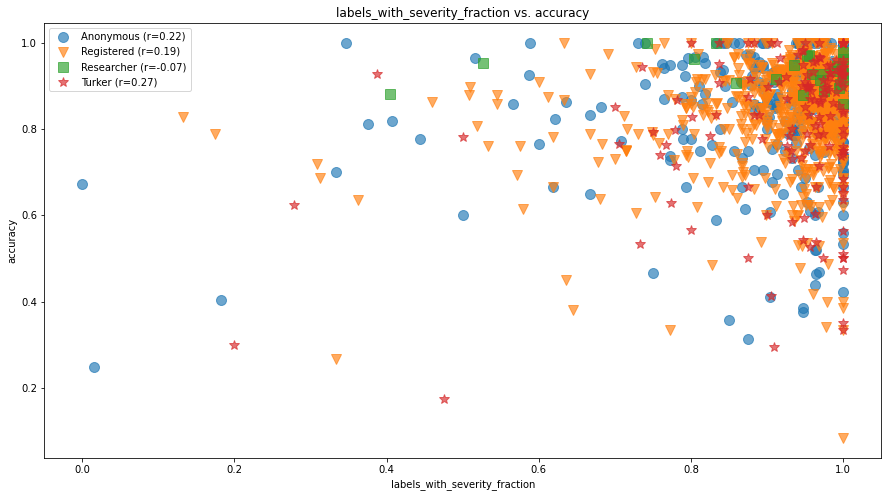

In [61]:
plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy');

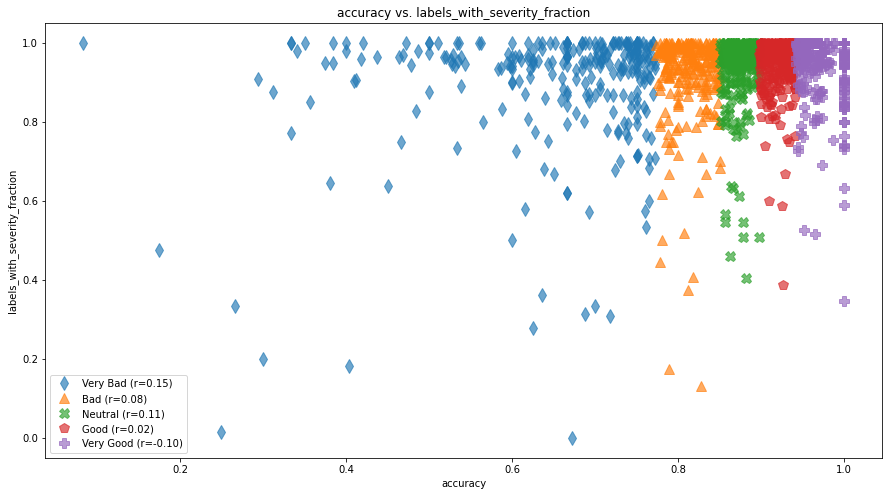

In [62]:
plot_scatter(df_users, 'accuracy', 'labels_with_severity_fraction', groupby='user_quality_5bins');

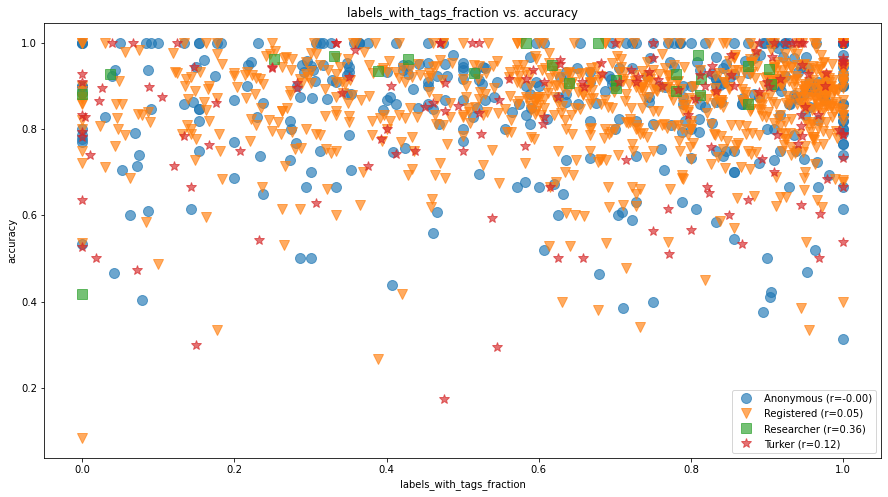

In [27]:
plot_scatter(df_users, 'labels_with_tags_fraction', 'accuracy');

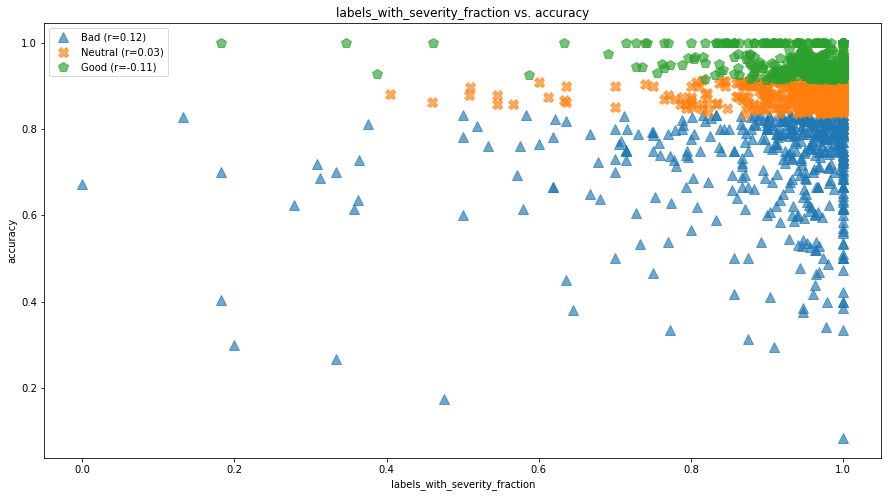

In [28]:
plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy', groupby='user_quality_3bins');

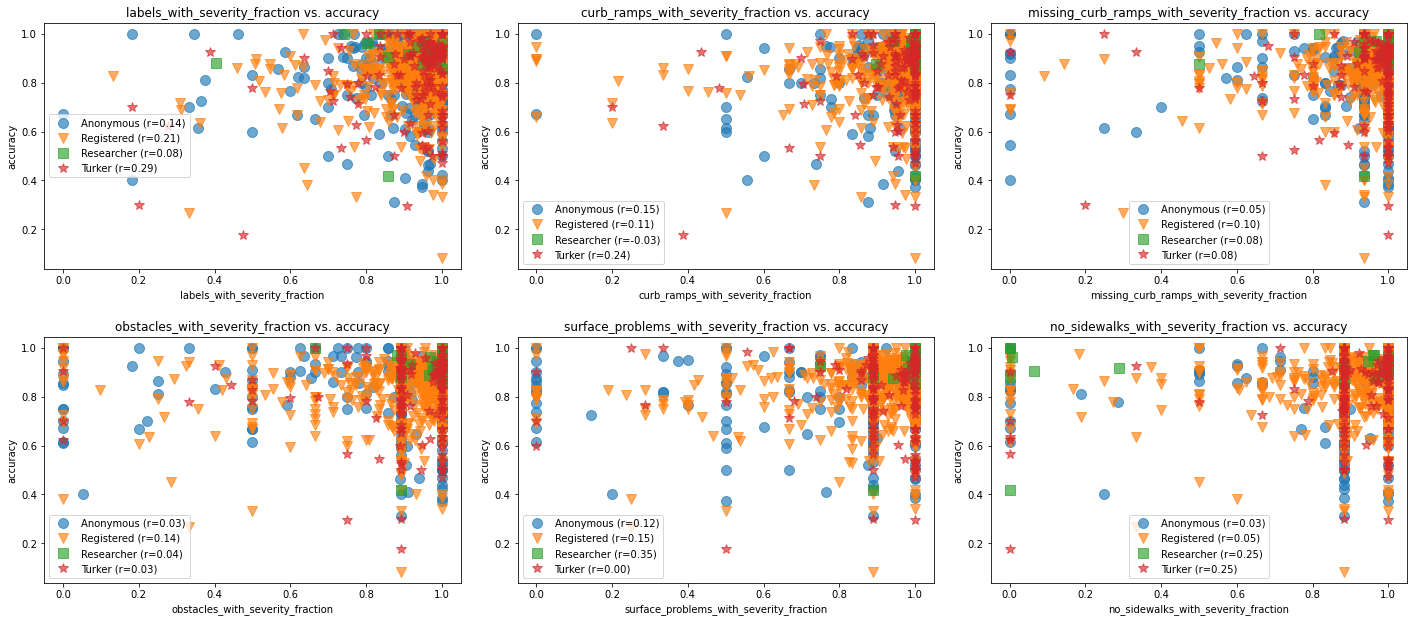

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy', ax = axes[0][0])
plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])
plt.tight_layout(pad=2)

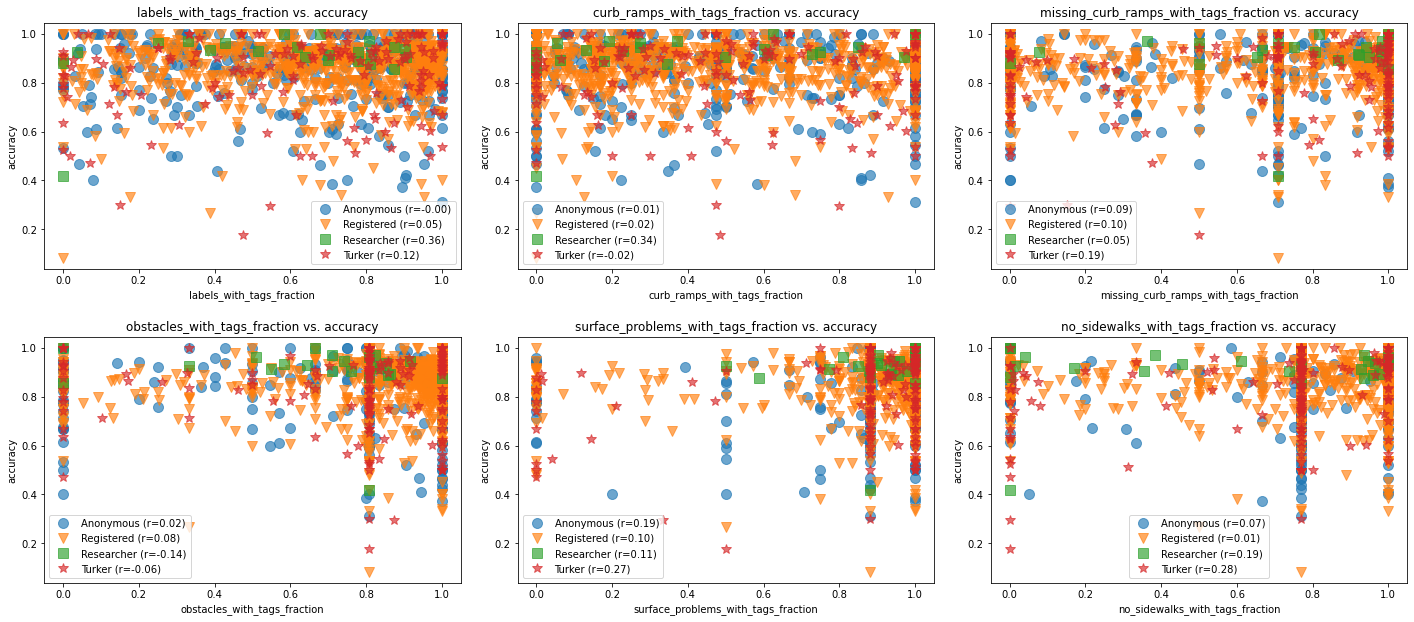

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

plot_scatter(df_users, 'labels_with_tags_fraction', 'accuracy', ax = axes[0][0])
plot_scatter(df_users, 'curb_ramps_with_tags_fraction', 'accuracy', ax = axes[0][1])
plot_scatter(df_users, 'missing_curb_ramps_with_tags_fraction', 'accuracy', ax = axes[0][2])
plot_scatter(df_users, 'obstacles_with_tags_fraction', 'accuracy', ax = axes[1][0])
plot_scatter(df_users, 'surface_problems_with_tags_fraction', 'accuracy', ax = axes[1][1])
plot_scatter(df_users, 'no_sidewalks_with_tags_fraction', 'accuracy', ax = axes[1][2])
plt.tight_layout(pad=2)

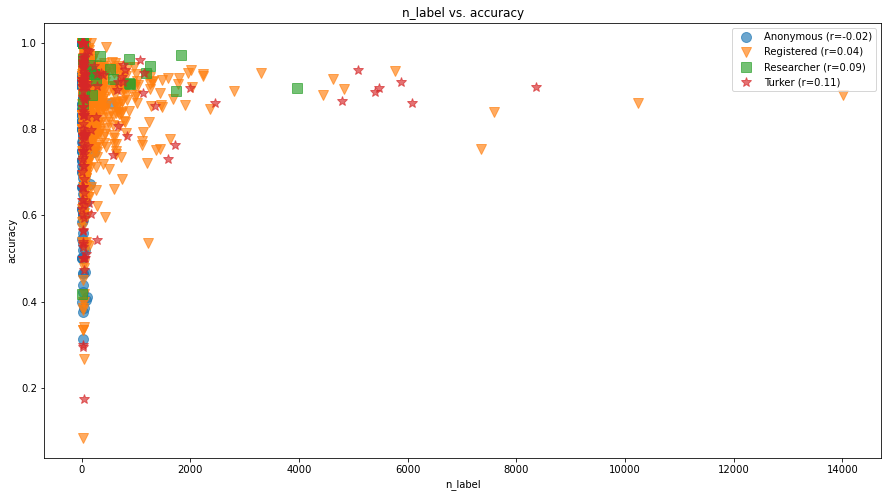

In [34]:
plot_scatter(df_users, 'n_label', 'accuracy');

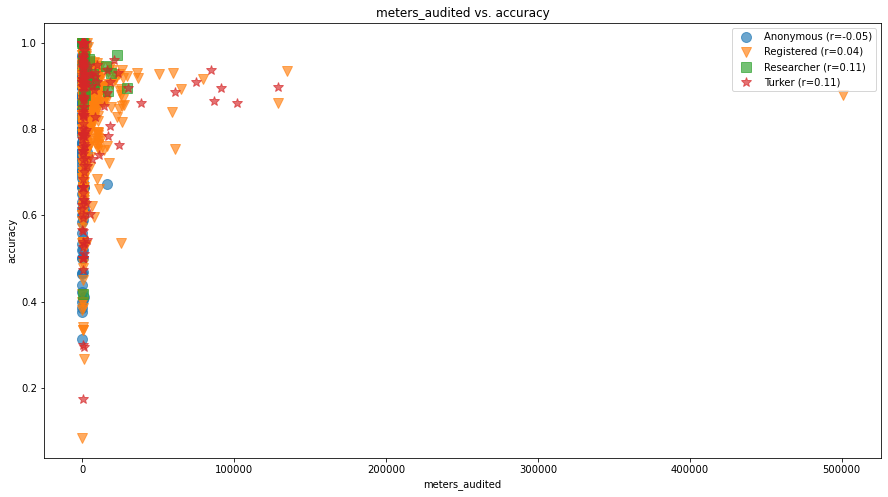

In [35]:
plot_scatter(df_users, 'meters_audited', 'accuracy');

# Accuracy as a function of role

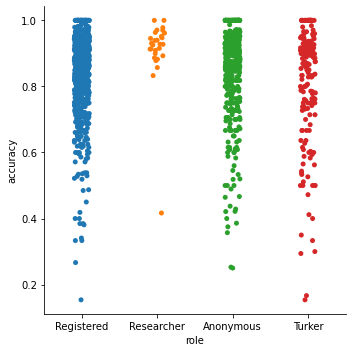

In [61]:
# from: https://seaborn.pydata.org/tutorial/categorical.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
sns.catplot(x="role", y="accuracy", jitter=True, data=df_users);

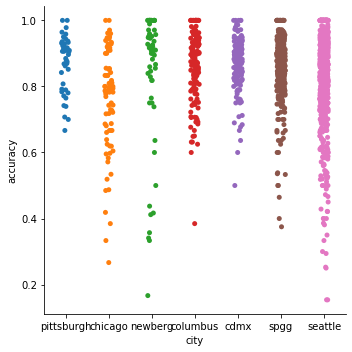

In [62]:
# Accuracy as a function of city
# from: https://seaborn.pydata.org/tutorial/categorical.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
sns.catplot(x="city", y="accuracy", jitter=True, data=df_users);

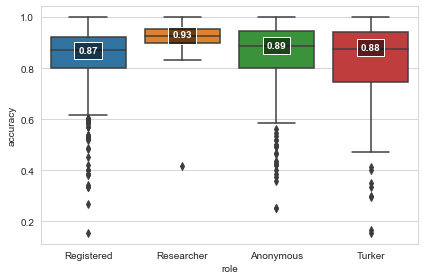

In [97]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot
sns.set_style("whitegrid")
# sns.catplot(x="role", y="accuracy", kind="box", data=df_users, height=6);
box_plot = sns.boxplot(x="role", y="accuracy", data=df_users)

# add in values
# from: https://stackoverflow.com/a/56879116
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0], 2) 

    ax.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold', 
        size=10, color='w', bbox=dict(facecolor='#00000088'))

box_plot.figure.tight_layout()
#display_overview(df_users)

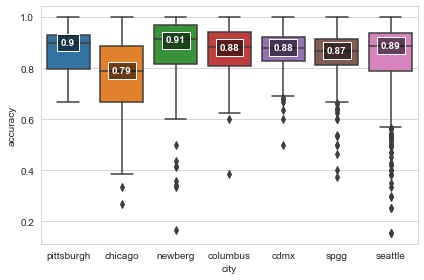

In [98]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot
sns.set_style("whitegrid")
# sns.catplot(x="role", y="accuracy", kind="box", data=df_users, height=6);
box_plot = sns.boxplot(x="city", y="accuracy", data=df_users)

# add in values
# from: https://stackoverflow.com/a/56879116
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0], 2) 

    ax.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold', 
        size=10, color='w', bbox=dict(facecolor='#00000088'))

box_plot.figure.tight_layout()
#display_overview(df_users)

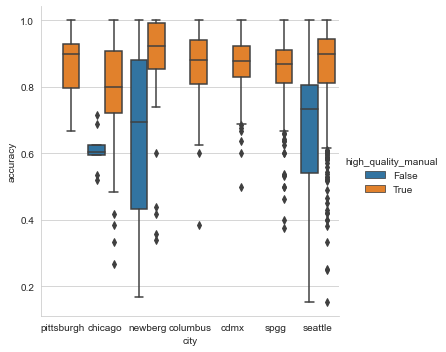

In [99]:
sns.catplot(x="role", y="accuracy", kind="box", hue='high_quality_manual', data=df_users);

## Histograms

### Histogram of accuracy

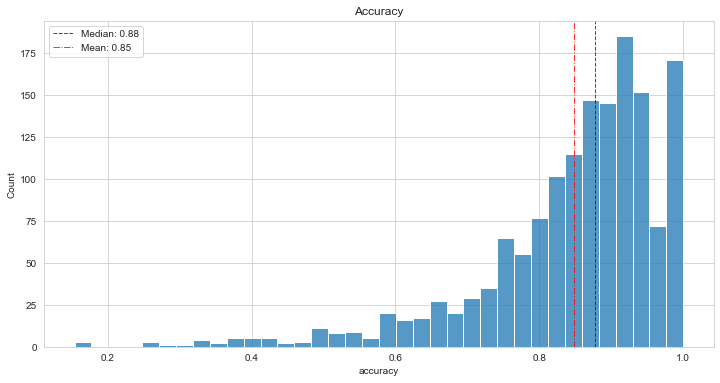

In [64]:
import seaborn as sns, numpy as np

plt.figure(figsize=(12, 6))
ax = sns.histplot(df_users['accuracy'])
plt.axvline(np.median(df_users['accuracy']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['accuracy']):0.2f}", linewidth=1, alpha=0.8)
plt.axvline(np.mean(df_users['accuracy']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['accuracy']):0.2f}", linewidth=1, alpha=0.8)
ax.set_title('Accuracy')
plt.legend();

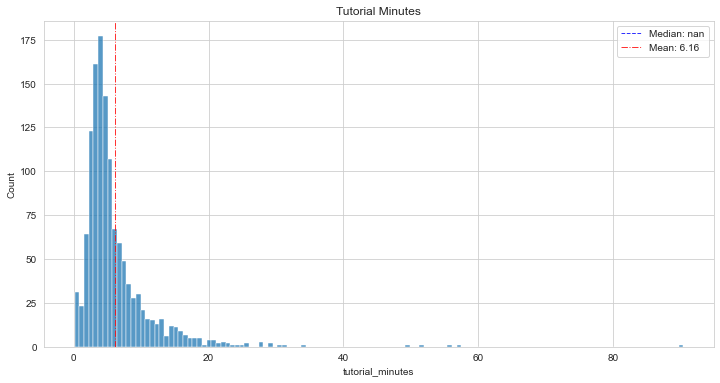

In [65]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(df_users['tutorial_minutes'])
plt.axvline(np.median(df_users['tutorial_minutes']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['tutorial_minutes']):0.2f}", linewidth=1, alpha=0.8)
plt.axvline(np.mean(df_users['tutorial_minutes']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['tutorial_minutes']):0.2f}", linewidth=1, alpha=0.8)
ax.set_title('Tutorial Minutes')
plt.legend();

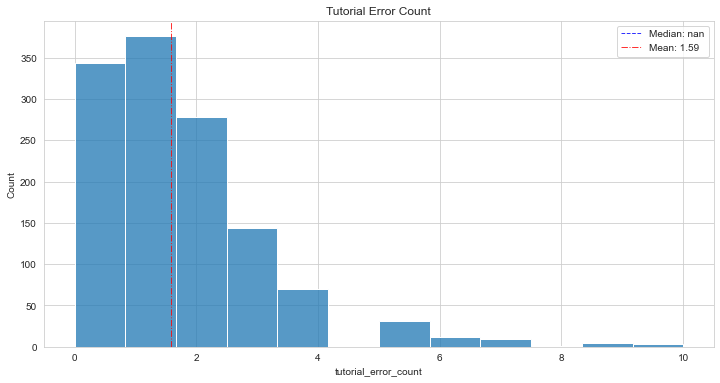

In [66]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(df_users['tutorial_error_count'], bins=12)
plt.axvline(np.median(df_users['tutorial_error_count']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['tutorial_error_count']):0.2f}", linewidth=1, alpha=0.8)
plt.axvline(np.mean(df_users['tutorial_error_count']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['tutorial_error_count']):0.2f}", linewidth=1, alpha=0.8)
ax.set_title('Tutorial Error Count')
plt.legend();

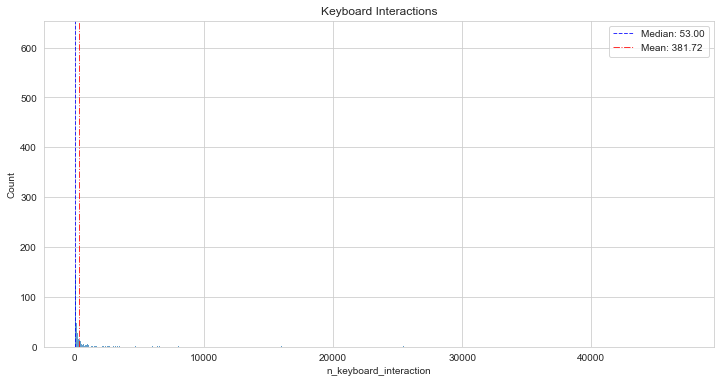

In [74]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(df_users['n_keyboard_interaction'])
plt.axvline(np.median(df_users['n_keyboard_interaction']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['n_keyboard_interaction']):0.2f}", linewidth=1, alpha=0.8)
plt.axvline(np.mean(df_users['n_keyboard_interaction']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['n_keyboard_interaction']):0.2f}", linewidth=1, alpha=0.8)
ax.set_title('Keyboard Interactions')
plt.legend();

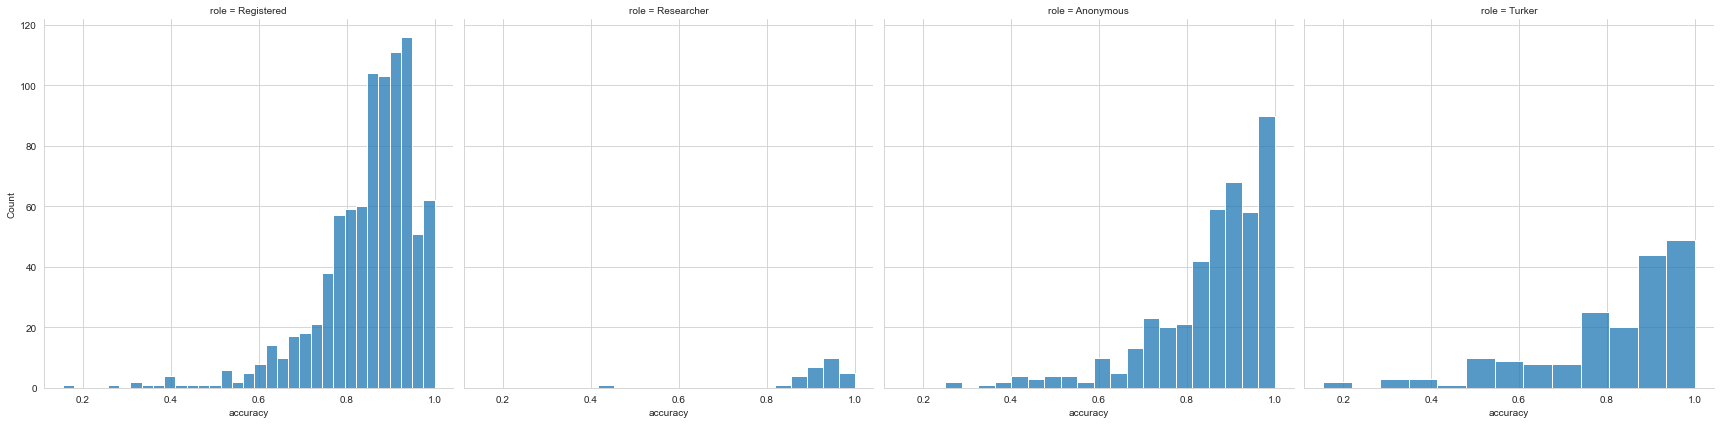

In [69]:
# https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/
g = sns.FacetGrid(df_users, row=None, col='role', height = 6)
g.map(sns.histplot, "accuracy")
plt.show()

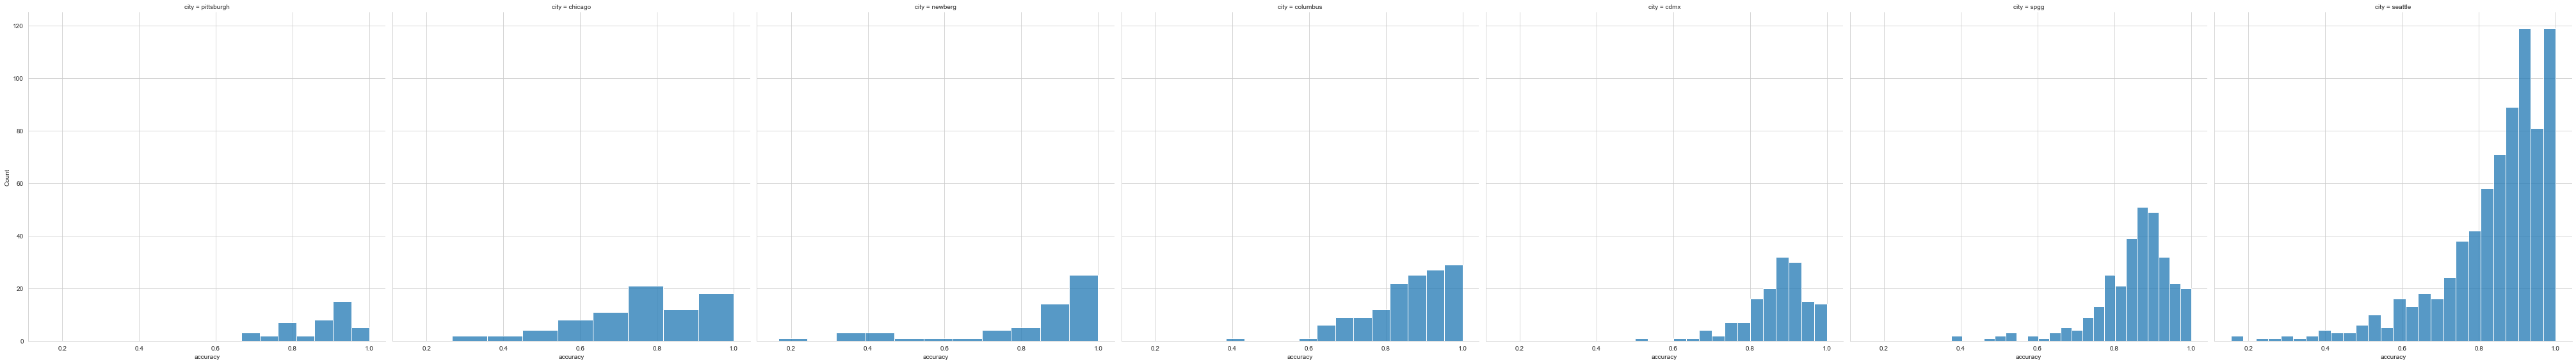

In [71]:
g = sns.FacetGrid(df_users, row=None, col='city', height = 8)
g.map(sns.histplot, "accuracy")
plt.show()

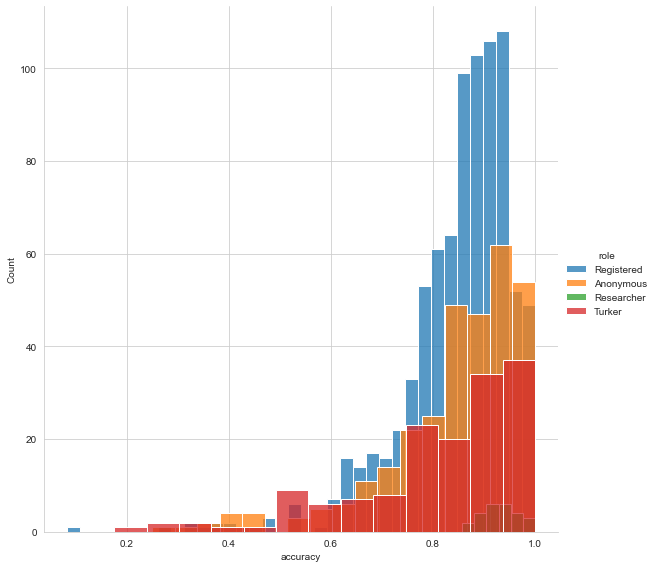

In [82]:
# fig, ax = plt.subplots(figsize=(10, 8))
g = sns.FacetGrid(df_users, hue="role", height=8)
g = g.map(sns.histplot, "accuracy");
g.add_legend()

### Histogram of labels/meter

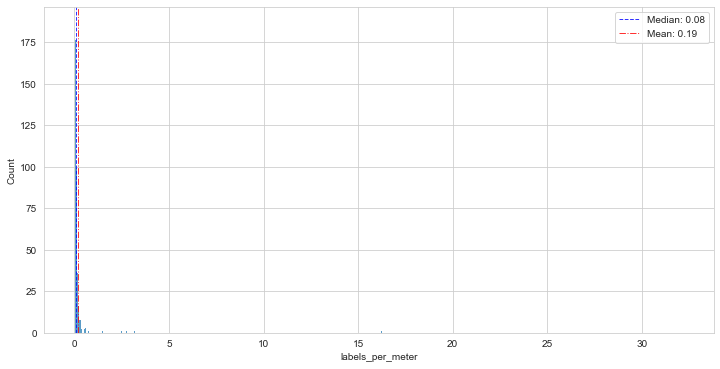

In [72]:
plt.figure(figsize=(12, 6))
col = 'labels_per_meter'
ax = sns.histplot(df_users[col])
plt.axvline(np.median(df_users[col]), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users[col]):0.2f}", linewidth=1, alpha=0.8)
plt.axvline(np.mean(df_users[col]), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users[col]):0.2f}", linewidth=1, alpha=0.8)
plt.legend();

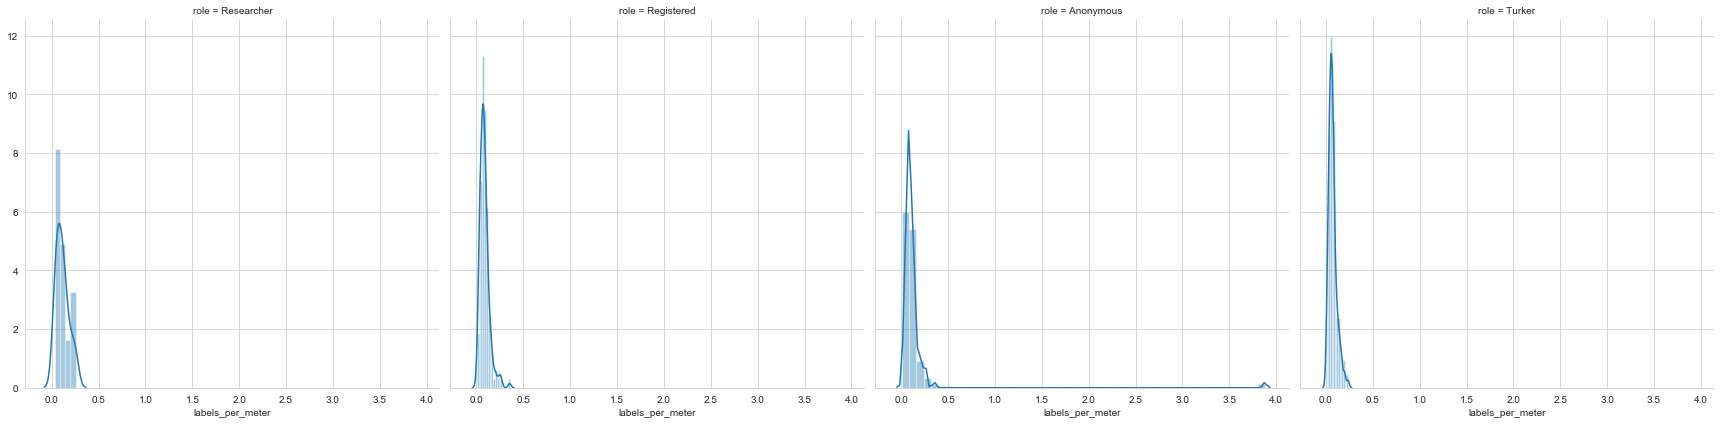

In [120]:
g = sns.FacetGrid(df_users, col='role', height = 6)
g.map(sns.distplot, "labels_per_meter")

## Joint ploints

ValueError: cannot reindex from a duplicate axis

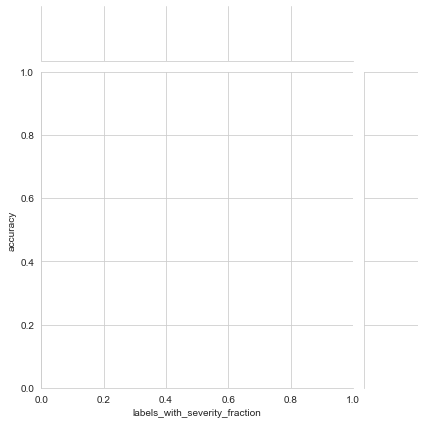

In [43]:
j = sns.jointplot(data=df_users, x='labels_with_severity_fraction', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr) # from: https://stackoverflow.com/a/52119784
plt.show()

ValueError: cannot reindex from a duplicate axis

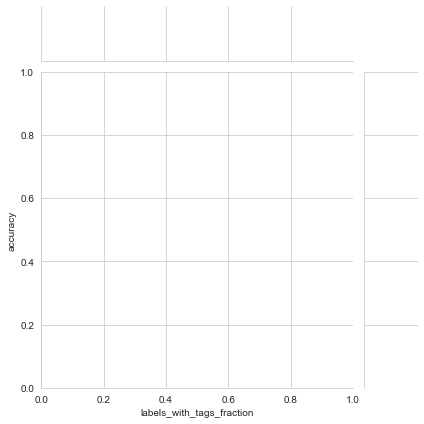

In [44]:
j = sns.jointplot(data=df_users, x='labels_with_tags_fraction', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr) # from: https://stackoverflow.com/a/52119784
plt.show()

AttributeError: 'JointGrid' object has no attribute 'annotate'

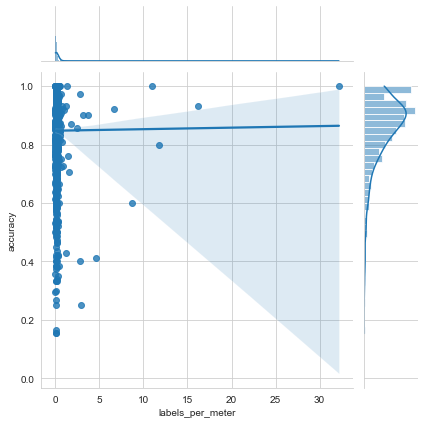

In [96]:
j = sns.jointplot(data=df_users, x='labels_per_meter', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr)
plt.show()

# Regression predictions

In [95]:
# https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
# plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
# plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
# plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
# plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])

input_feature_cols = []

# Add in labels/meter input features
input_feature_cols.extend(['labels_per_meter'])
input_feature_cols.extend(['curb_ramp_labels_per_meter', 'missing_curb_ramp_labels_per_meter', 
                           'obstacle_labels_per_meter', 'surface_problem_labels_per_meter', 'no_sidewalk_labels_per_meter'])

# Add in severity input features
input_feature_cols.extend(['labels_with_severity_fraction'])
input_feature_cols.extend(['missing_curb_ramps_with_severity_fraction',
              'obstacles_with_severity_fraction', 'surface_problems_with_severity_fraction', 
              'curb_ramps_with_severity_fraction', 'no_sidewalks_with_severity_fraction'])

# Add in tag input features
input_feature_cols.extend(['labels_with_tags_fraction'])
input_feature_cols.extend(['missing_curb_ramps_with_tags_fraction',
              'obstacles_with_tags_fraction', 'surface_problems_with_tags_fraction', 
              'curb_ramps_with_tags_fraction', 'no_sidewalks_with_tags_fraction'])

X = df_users[input_feature_cols]

#X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction']]
y = df_users['accuracy'].values

# TODO: update this to be k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
display(coeff_df)

y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(df.sample(10))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

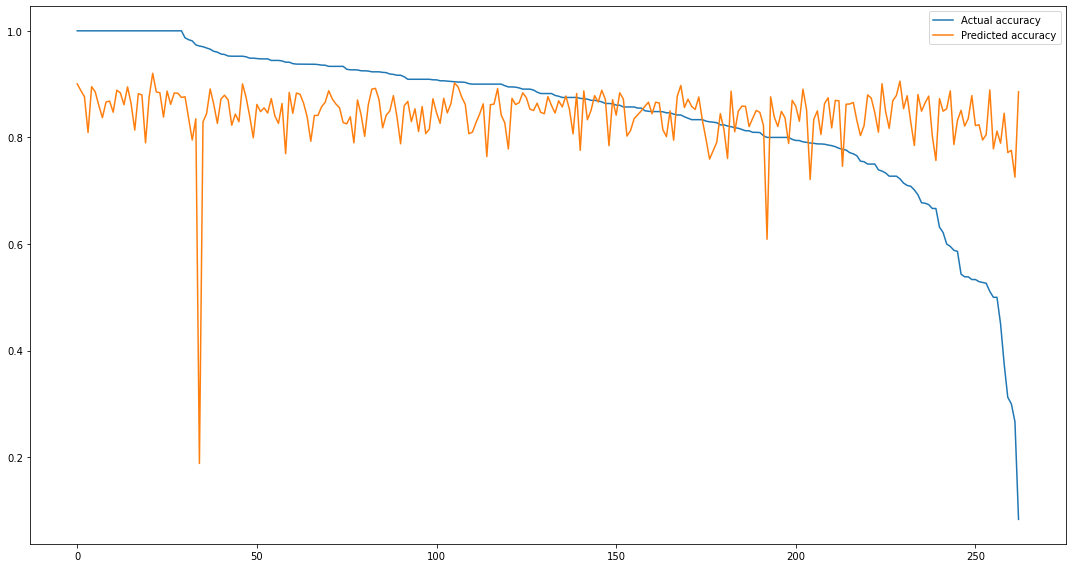

In [14]:
sorted_indices = y_test.argsort()[::-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(y_test[sorted_indices], label="Actual accuracy")
ax.plot(y_pred[sorted_indices], label="Predicted accuracy")
ax.legend()
fig.tight_layout()

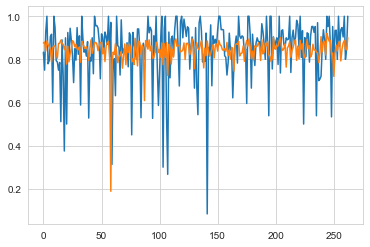

In [47]:
plt.plot(y_test)
plt.plot(y_pred)

# User classification

In [8]:
from sklearn import svm
from sklearn.metrics import accuracy_score

df_users["user_quality_3bins"] = df_users["user_quality_3bins"].astype('category')
df_users["user_quality_3bins_cat"] = df_users["user_quality_3bins"].cat.codes

# X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction',
#               'missing_curb_ramps_with_severity_fraction',
#               'obstacles_with_severity_fraction', 'surface_problems_with_severity_fraction', 
#               'curb_ramps_with_severity_fraction', 'no_sidewalks_with_severity_fraction']]
#X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction']]
y = df_users['user_quality_3bins']

# display(X)
# display(y)

# TODO: update this to be k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.39923954372623577

Overall SVM accuracy: 43.26%
              precision    recall  f1-score   support

         Bad       0.52      0.38      0.44       455
        Good       0.42      0.52      0.47       437
     Neutral       0.38      0.40      0.39       421

    accuracy                           0.43      1313
   macro avg       0.44      0.43      0.43      1313
weighted avg       0.44      0.43      0.43      1313



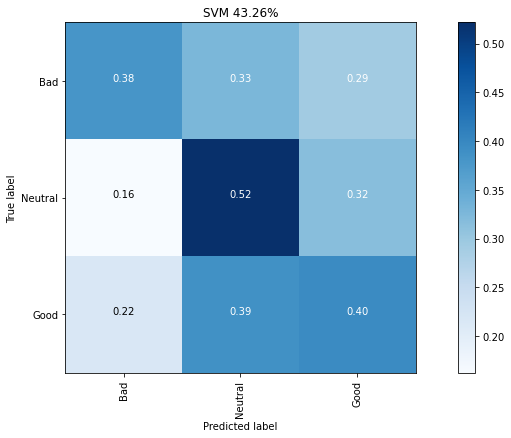

In [9]:
kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

clf = svm.SVC(kernel='linear', C=1)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall SVM accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
graph_title = f"SVM {accuracy_score(y, y_pred) * 100:.2f}%"
plot_confusion_matrix(cm, classes = ["Bad", "Neutral", "Good"], title=graph_title, normalize=True)
# grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

In [134]:
df_users.groupby('quality_3bins').describe()

validations_received_count                                      \
                                   count        mean         std   min   25%   
quality_3bins                                                                  
Bad                                137.0   76.751825  170.858721  11.0  18.0   
Neutral                            141.0  168.049645  412.948619  11.0  23.0   
Good                               132.0  142.030303  399.523112  11.0  14.0   

                                   accuracy             ...  \
                50%    75%     max    count       mean  ...   
quality_3bins                                           ...   
Bad            30.0   68.0  1519.0    137.0  50.507683  ...   
Neutral        42.0  102.0  2785.0    141.0  73.111286  ...   
Good           23.0   56.5  2921.0    132.0  88.706088  ...   

              surface_problems_with_severity_fraction       \
                                                  75%  max   
quality_3bins                                                
Bad                                               1.0  1.0   
Neutral                                           1.0  1.0   
Good                                              1.0  1.0   

              no_sidewalks_with_severity_fraction                           \
                                            count      mean       std  min   
quality_3bins                                                                
Bad                                         137.0  0.851576  0.247911  0.0   
Neutral                                     141.0  0.911000  0.150522  0.0   
Good                                        132.0  0.921587  0.114386  0.0   

                                             
                    25%       50%  75%  max  
quality_3bins                                
Bad            0.894552  0.894552  1.0  1.0  
Neutral        0.894552  0.911111  1.0  1.0  
Good           0.894552  0.894552  1.0  1.0  

[3 rows x 192 columns]

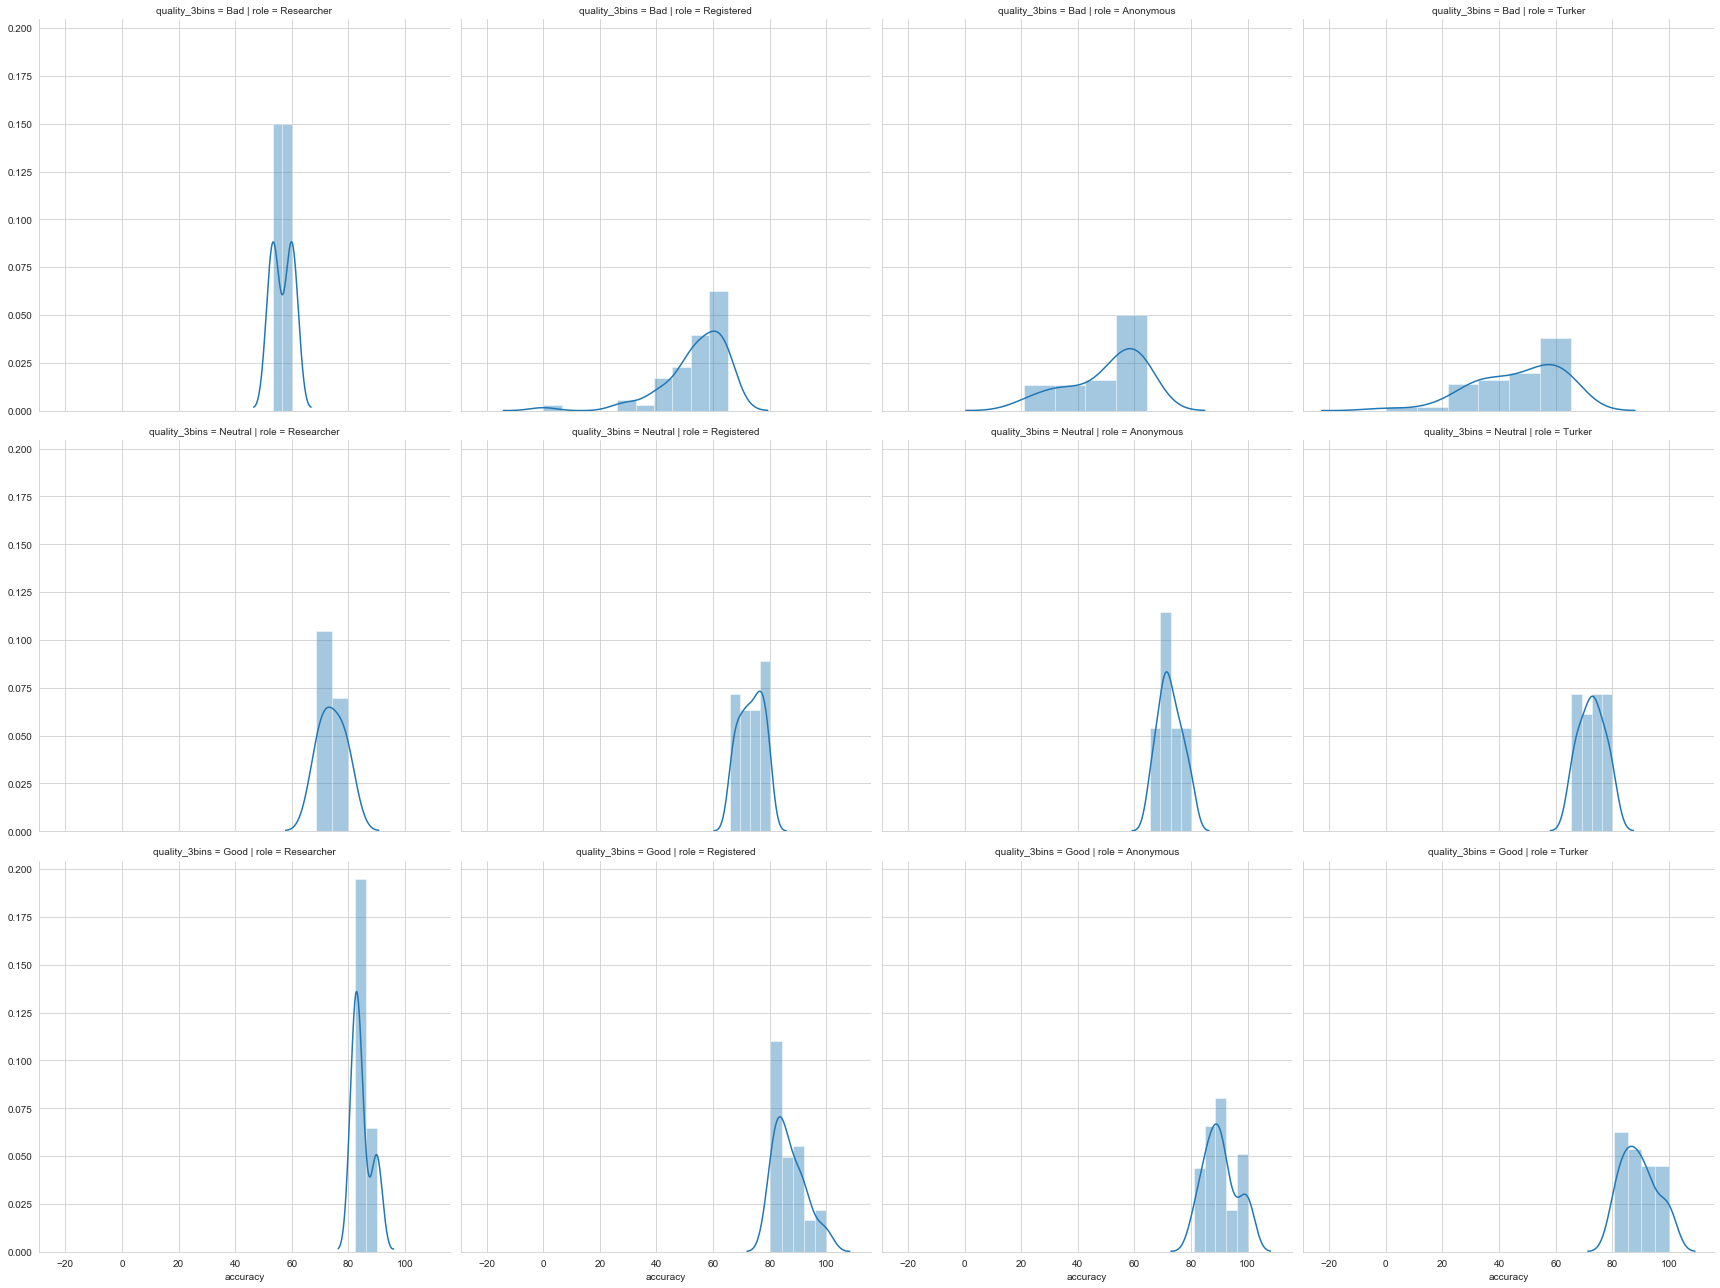

In [133]:
g = sns.FacetGrid(df_users, row='quality_3bins', col='role', height = 6)
g.map(sns.distplot, "accuracy")
plt.show()

# Sandbox

## Pairwise correlations

In [51]:
pairwise_corr = df_users.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_corr, square=True, annot=True)
plt.title(f"Pairwise correlation of input features")

Text(0.5, 1.0, 'Pairwise correlation of input features')

Error in callback <function flush_figures at 0x00000189BC6E3A60> (for post_execute):


KeyboardInterrupt: 

## Pairplots

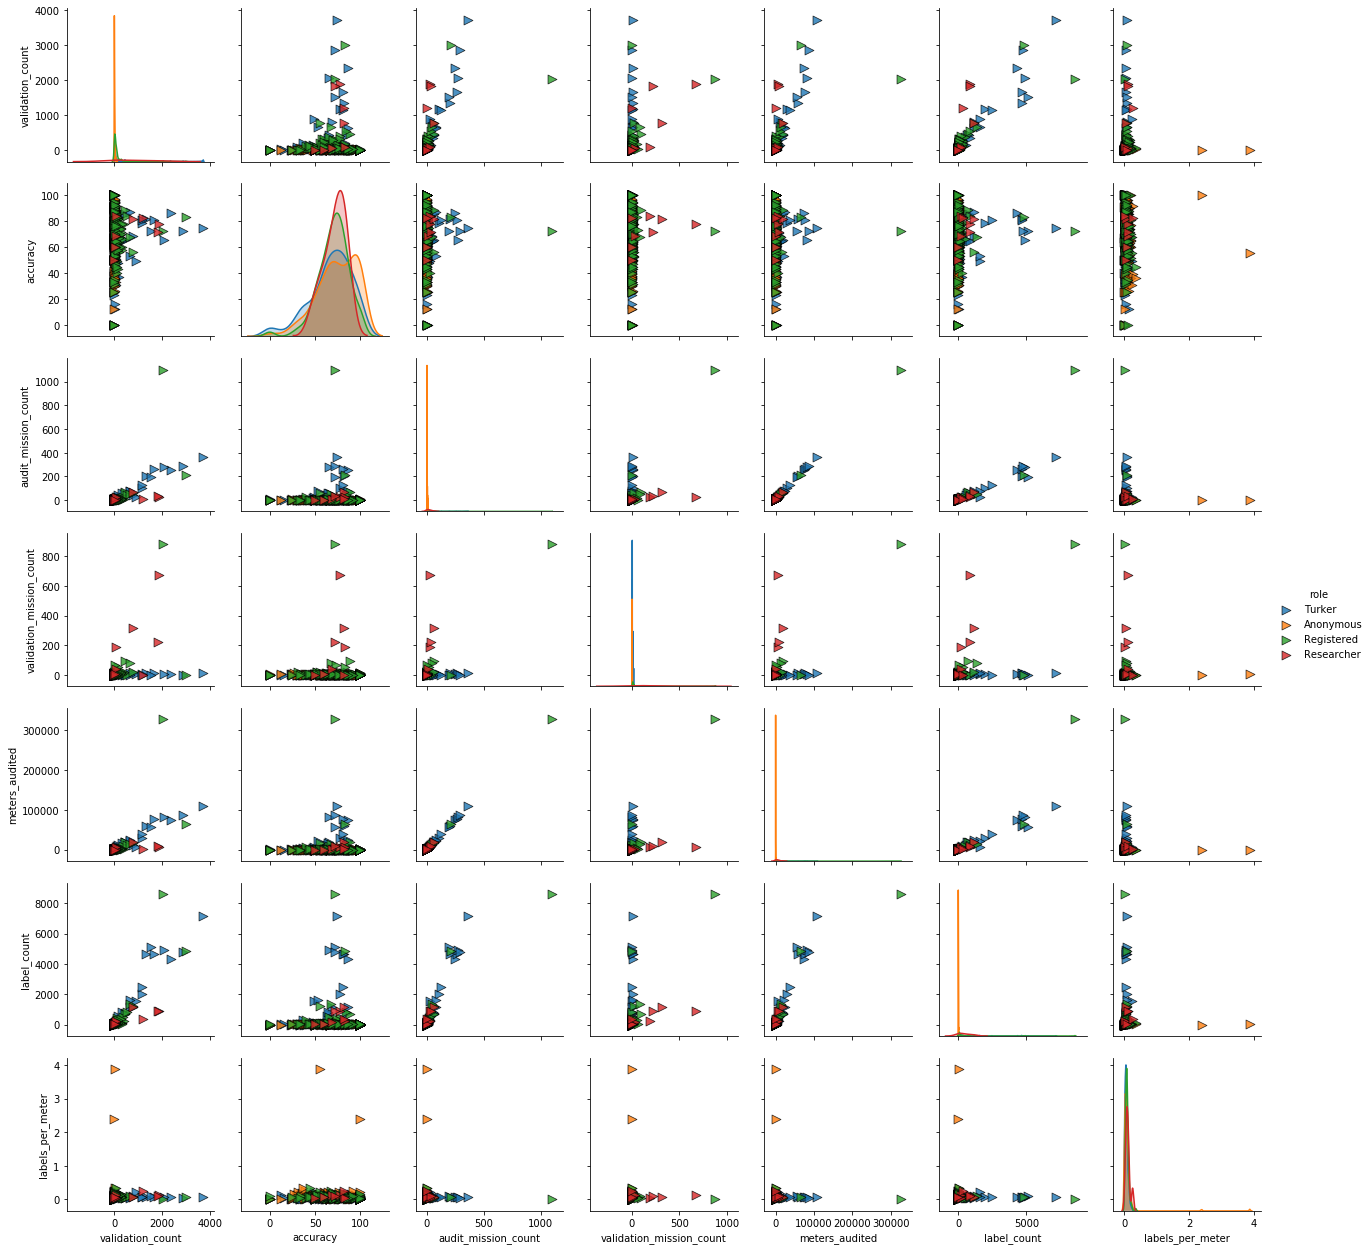

In [122]:
# Create the pairplot (this might take a bit of time)
markers = plot_markers[4]
sns.pairplot(df_users, hue="role", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);